----
Computational Statistics | Final Project | Summer 2021 | M.Sc. Economics, Bonn University | Matriculation number: 3288942

# On forbidden regressions: Using Random Forest, Boosting and Logistic regression for  first stage IV prediction

[Carolina Alvarez Garavito](https://github.com/carolinalvarez)






-----

# Table of contents

* [Introduction](#Introduction)
* [Research Question](#r)
    * [Endogeneity problem](#end)
    * [One instrument case - example](#one)
    * [ML methods for first stage prediction](#ml)
* [Nonlinear Methodologies ](#methods)
    * [Random Forest](#rf)
    * [Boosting](#boost)
    * [Logit regression](#logit)
    * [Methods performances ](#perf)
* [Simulation Study](#sim)
    * [Baseline DGP](#base)
    * [Case A - One instrument, no covariates](#A)
    * [Case B - Lennon et al. (2021) replication](#B)
    * [Case C - changing tuning parameters for boosting](#C)
    * [Case D - no correlated set of instruments](#D)
    * [Case E - one instrument and set of covariates](#E)
    * [Case F - nonlinear first stage regression](#F)
* [Data Aplication](#data)
    * [Angrist and Evans (1998)](#angrist)
    * [First stage using random forest, boosting and logistic regression](#first)
    * [Second stage estimates](#second)
* [Conclusion](#conclusion)
* [References](#ref)


---------
# Introduction <a class="anchor" id="Introduction"></a>

Machine learning (ML) methods are gaining popularity in empirical econometric applications, especifically in settings where researchers are interested in an outcome variable prediction, as for example in research regarding consumer demand forecast. 
As Mullainathan and Spiess (2017) point out, ML revolves around the problem of prediction of $y$ from $x$ and its appeal comes from its ability to accomodate complex data structure and patterns.

However, little research has been conducted regarding the performance of the ML toolkit in the field of instrumental variables (IV). Most empirical economic questions that use tools like IV are less concerned about prediction ($\hat{y}$) but rather interested in parameter estimation. Mullainathan and Spiess (2017) recognize that ML algorithms are not made for this purpose, and even if ML produce some type of regression coefficients, these are rarely consistent. In other words, machine learning belongs to the toolkit concerning $\hat{y}$, rather than $\hat{\beta}$. 

But even if the researcher is interested in estimating the parameter $\hat{\beta}$, the first stage of a 2SLS method is a prediction problem, in the sense that one aims to predict $\hat{x}$ through an exogenous instrument (and some exogenous covariates) in order to plug in fitted values into a second stage to successfully recover $\hat{\beta}$. Here, the prediction ability of ML methods may sound appealing, in the sense that better first stage predictions may help to produce more precise second-stage estimates (Angrist and Frandsen, 2019; Mullainathan and Spiess, 2017; Lennon et al., 2021). 

The extent to which ML algorithms actually outperform OLS first stage prediction and thus second stage $\hat{\beta}$ estimation is a field with very few academic exploration yet.  Angrist and Frandsen (2019) find, among other results, that applying ML methods to first-stage estimation with one instrument and many covariates might lead to the creation of an artificial exclusion restriction (that is, that $y$ is only affected by a variation in the treatment assignment through the instrument) that lead to misleading second stage estimates. Lennon et al (2021) find that using tree based methods in the first stage creates biased estimates in the second stage- some of them exceeding the bias generated by a naive OLS procedure. Chen et al. (2021) are more optimistic, arguing that using first-stage ML predictions as instruments in a normal 2SLS procedure is helpful to extract non-linear covariation and improve second-stage estimation. 

This project aims to contribute to this new empirical debate by partially replicating the research conducted by Lennon et al. (2021) and extend it to check whether their results are sensitive to the initial data generation process specification. Moreover, in a second part, I follow Angrist and Frandsen (2019) and apply the methods to the Angrist and Evans (1998) Census data, in order to analyze the performance of the ML algorithms when compared to 2SLS estimations of the effect of childbearing on women labor supply. 

-----

# Research Question <a class="anchor" id="r"></a>

## Endogeneity problem <a class="anchor" id="end"></a>

Usually, instrumental variables are used to estimate the causal effect of some variable $x$ on some output $y$ in a case when the OLS exogeneity assumption cannot be assumed and therefore, it is violated. Regression models may suffer from endogeneity problems because of omitted variables, measurement errors and simultaneous causality. 

Consider the following model:

   \begin{equation}
   y= \beta_0 + \beta_1 x + u
   \end{equation}

where there is a potential non-zero covariance between the variable of interest $x$ and the error term $u$ when estimating the effect of $x$ on $y$, which is $\beta_1$. That is:

   \begin{equation}
   E(x|u)\neq 0
   \end{equation}

so strict exogeneity (and orthogonality) between $x$ and $u$ do not hold. In this setting, OLS estimation for the parameter $\beta_1$ is inconsistent and biased for the true value of the parameter. Thus, researchers use an instrument $z$ to obtain a consistent estimator of $\beta_1$.

In order to be considered as a a valid instrument, $z$ must satisfy two conditions:instrument relevance condition: $x$ and $z$ must be correlated, therefore $E(x|z)\neq 0$; Instrument exogeneity condition: $z$ must be uncorrelated with the error term, then $E(z|u) = 0$


## One instrument case - example  <a class="anchor" id="one"></a>

Two-Stage Least Squares (TSLS or 2SLS) applies OLS into two stages. In the first stage, the variation in the endogenous regressor $x$ is decomposed into a endogenous free compponent that is explained by the exogenous instrument $z$ and a problematic component correlated with the error term $u$. The second stage proceeds then by only using the "good variation" (the problem free component) in $x$ explained by $z$ to estimate $\beta_1$. In the model stated above, the first stage regression of the model will be:

   \begin{equation}
   x = \pi_0 + \pi_1 z + \varepsilon
   \end{equation}

where $\pi_0 + \pi_1 z$ is the component of $x$ explained by $z$ while \varepsilon is the component that cannot be explained by the instrument and presents a correlation with the error term of the model, $u$. Runing an OLS regression on the first stage will produce estimates of $\hat{\pi_0}$ and $\hat{\pi_1}$ that then will generate a predicted value for $x$:

   \begin{equation}
   \hat{x} = \hat{\pi_0} + \hat{\pi_1} z
   \end{equation}

If the instrument fullfils the conditions to be considered as a valid instrument, then the predicted values $\hat{x}$ will be exogenous, and thus one can run a second stage regression through OLS using $\hat{x}$ as an independent variable. The second stage then produces $\hat{\beta}^{2SLS}_0$ and $\hat{\beta}^{2SLS}_1$, the two-stage least squares estimators of the true parameters $\beta_0$ and $\beta_1$.  The 2SLS estimator is a consistent estimator for the true parameter $\beta_1$ under the assumption that it is a valid instrument. The Central Limit Theorem (CLT) implies that the distribution of the $\hat{\beta}^{2SLS}_1$ can be approximated by a normal distribution with mean $\beta_1$ if the sample size $n$ is large enough.

 
## ML methods for first stage prediction <a class="anchor" id="ml"></a>

The first stage of the 2SLS method involves a **prediction problem**; that is, we are interested in predicting the endogenous variable by extracting only its exogenous variation. Since machine learning (ML) methods are built to make better predictions, one could argue that by using ML methodologies could improve first stage predictions and then yield better results in the second stage. 

However, in their book Mostly Harmless Econometrics (2008), Angrist and Pischke define some "Forbidden Regressions" as one type of mistake made when estimating 2SLS. According to the authors: "*A forbidden regression crops up when researchers apply 2SLS reasoning directly to non-linear models*" (pg. 142). For example, suppose that there exist an endogenous variable $D$ that happens to be a dummy variable, so the first stage prediction is a linear regression of $D_i$ on covariates $X_i$ and the instrument $Z_i$:

   \begin{equation}
   D_i = \pi_0 + \pi_1 Z_i + \pi_2 X_i + \varepsilon_i
   \end{equation}
   
Because $D_i$ is a dummy, the conditional expectation function (CEF) of this first stage $E[D_i|X_i, Z_i]$ might be non-linear. This means that if one runs an OLS regression on the first stage, this would end up being an approximation of the underlying non-linear CEF. A rational idea would then be to use a non-linear method for better approximating $D_i$, in this case a Probit or Logit model. If applying a logit model in the first stage, the "forbidden regression" is the second stage equation, when we substitute $\hat{D}_i$ for $D_i$. The problem is that only OLS guarantees that the first-stage residuals are uncorrelated with the fitted values and other covariates. If this assumption is violated, the second stage estimates could be biased.

Lennon et al. (2021) explore this idea further by focusing on the appealing idea that ML methods could be a better approximation for curating and generating better first-stage predictions of 2SLS. They show that ML solutions actually generate more bias when plugged into the second stage. In this project, I try to replicate the findings of Lennon et al. (2021) - specifically, the result that Random Forest and Boosted trees generate a considerable amount of bias when estimating the true parameter. I follow closely their simulation study and apply some variations to explore when ML methods perform better than OLS in predicting the endogenous variable and whether this could end up in less biased results.

In the next paragraphs I describe each ML procedure to be implemented later in the application part.

# Nonlinear Methodologies  <a class="anchor" id="methods"></a>

## Random Forest <a class="anchor" id="rf"></a>

Random forest are an ensemble learning method that uses multiple trees and can be used either as a random forest of regression trees or random forest of classification trees. The mechanism behind the random forest method is to build a specific number of decision trees on a boostrapped training sample. Here, each time a split in a tree is considered, a *random sample* of *m predictors* is chosen as split candidates from the full set of *p predictors*. Typically, $m$ is chosen as $m{\displaystyle \approx }\sqrt{p}$ for classification purposes, which means that the number of predictors considered at each split is approximately equal to the square root of the total number of predictors. For regression purposes, random forest uses *p/3* predictors. (James et al, 2013). 

The reason for doing so is that, unlike bagging (another tree based method), random forest avoids a potential correlation between the trees to assure the maximum reduction of variance by forcing each split to consider only a subset of predictors. This is specially important when there is one very strong predictor and *k* other moderatly strong predictors. Random forest will, on average, a number of $(p-m)/p$ times not consider the strong predictor, so other predictors have more chance to enter in the building of the tree (James et al, 2013). 

A typical procedure of random forest uses the following steps (Varian, 2014):

1. Choose a bootstrap sample of the observations and start growing a tree.
2. At each node of the tree, choose a random sample of the predictors to make the next decision, without pruning the trees. 
3. Repeat the process many times to grow a forest of trees.
4. In a regression context, the prediction of a continuous variable is then the average of the prediction of the variable within all the trees grown. As for classification, a majority vote for the final prediction is used. 

## Boosting <a class="anchor" id="boost"></a>

Boosting is another tree-based method for improving model accuracy, based on building sequential trees for classification or regression. Here, decision trees are fitted iteratively to the training data set and each tree grows using information from previously grown trees. For regression purposes, boosting is a form of "functional gradient descendent" (Elith et al, 2008). Consider a measure that represents the deviance or loss in predictive performance due to a poor performance of the model, called the loss function. Boosting works as a optimization technique for minimizing such loss function by adding at each step a new tree that best reduces the loss function. In the regression setting, the first regression tree is the one that minimizes the most the lost function. Then, for each following step, the focus in on the residuals from the previous tree. The model then is stagewise, meaning that existing trees are left unchanged as the model is enlarged (Elith et al, 2008). The final boosting model is a linear combination of many trees (where each term of the 'regression' is a tree). 

Boosting models for regression can be fitted to a varierity of reponse variables, such as Gaussian (if continuous variable), Bernoulli (for binomial variables), among others. For the Bernoulli distribution setting, this can be thought also as a binary classification problem. 

Boosting has three important tuning parameters:

* The number of trees used for building the model $B$. Usually, cross validation is used for selecting the number of trees.

* The shrinking parameter $\lambda$, which is a positive number that controls the rate at which the boosting learns. The right lambda is set depending on the problem and the number of trees. Usually, a lower lambda is more efficient in terms of prediction, but the model will need more trees instead, which could increase the computational cost. 

* The number $d$ splits in each tree, which controls the complexity of the boosted trees.

The following summarizes the boosting algorithm (James et al, 2013). 

1. Set $\hat{f}(x)=0$ and $r_i=y_i$ for all $i$ in the training set. 
2. For $b=1,2,...,B$, repeat:
    
    a) Fit a tree $\hat{f}^b(x)$ with $d$ splits ($d+1$ terminal nodes) to the training data ($X, r$).
    
    b) Update $\hat{f}$ by ading a shrunken version of the new tree:
    
    \begin{equation}
    \hat{f}(x) \leftarrow \hat{f}^b(x) + \lambda \hat{f}^b(x)
    \end{equation}
    
    c) Update the residuals, 
    
    \begin{equation}
    r_i \leftarrow r_i + \lambda \hat{f}^b(x_i)
    \end{equation}

3. Output the boosted model 
    \begin{equation}
    \hat{f}(x) \leftarrow \sum_{b=1}^{B}\lambda \hat{f}^b(x)
    \end{equation}


## Logistic Regression <a class="anchor" id="logit"></a>

Logistic regression is purely a classification method, and it will only be used here in the data application section. Logistic regression models the probability that $Y$ belongs to a particular category. Formally, let us define $p(X)$ as the probability of a binary outcome $Y$ being equal to $1$ given $X$: as a linear function of $X$:

$$
\mathbb{P}\big( Y= 1| X):= p(X).
$$
We can either assume that $p(X)$ is linear in $X$$$
p(X) =\beta_{1}+\beta_{2} X,
$$

or we can use the logistic relationship:

$$
p(X)=\frac{e^{\beta_{1}+\beta_{2} X}}{1+e^{\beta_{1}+\beta_{2} X}}.
$$

After some manipulations:$$
\frac{p(X)}{1-p(X)}=e^{\beta_{1}+\beta_{2} X}
$$

This quantity is called the odds (can be anything between $0$ and $\infty$).

Taking the logarithm on both sides yields the log-odds or logit.

$$
\log \left(\frac{p(X)}{1-p(X)}\right)=\beta_{1}+\beta_{2} X
$$

## Methods performances <a class="anchor" id="perf"></a>

For testing the performance of random forest and boosting for first stage regression in the simulation study, I calculate the corresponding test MSE logistic regression. As for the real data aplication part, since it becomes a classification problem, I calculate the mean error rate of each method, which is the fraction of incorrect labels on the test data set.

-----------
# Simulation Study <a class="anchor" id="sim"></a>

Here I present a simulation study based on one of the settings proposed by Lennon et al (2021). I replicate their findings for their "low complexity scenario", and then I implement several changes to their initial Data Generating Process (DGP) in order to explore how their results are sensitive to different specifications. All the DGP simulate an endogeneity problem (in this case, an omitted variable bias) and I evaluate the performance of "naive" OLS, IV, Random Forest and Boosting for: i) how well they predict the first stage; ii) how close is $\hat{\beta}$ from the true parameter when the first stage predictions $\hat{x}$ of an IV regression, Random Forest and Boosting are plugged in a second OLS stage replacing $x$.

## Baseline DGP <a class="anchor" id="base"></a>

Following closely Lennon et al (2021), the DGP models a scenario with a single endogenous regressor ($x_1$) and a set of valid and individually strong instruments. The DGP is defined as follows:

\begin{align*}
\varepsilon_y&=\beta_2 x_2 + \eta \\
x_2&=1 + \varepsilon_c \\
x_1&=g_x(z) + \varepsilon_c
\end{align*}

where there is a  common disturbance $\varepsilon_c$ affecting $x_1$ (the endogenous regressor) and $x_2$ (the omitted variable). The common error $\varepsilon_c$ follows a standard normal distribution $\varepsilon_c \sim \mathcal{N}(0,\,1)\,$, whereas $\eta$ follows a uniform distribution from -1 to 1; $\eta \sim U(-1,\,1)\,.$ It is assumed that the set of instruments $z$ exists such that $E[\varepsilon_y|z]=0$ and $E[x_1|z] \neq 0$. The set of instruments is drawn from a multivariate normal distribution centered at zero, so $E[z]=0$ with variance-covariance matrix $\sum_z$ such that Cov$(z_i, z_j)=0.6$ and Var$(z_i)=1 \; \forall \; i \neq j.$

The data is generated then by the following system of equations:

\begin{align*}
y &= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \eta \\
x_2&=1 + \varepsilon_c \\
x_1&=g_x(z) + \varepsilon_c \\
\beta_0&=1 \\
\beta_1&=1 \\
\beta_2&=1 \\
\end{align*}


The following is a roadmap of the different specifications used to explore the sensitivity of the results found in Lennon et al (2021):

**A.** One instrument, no covariates

**B.** Several instruments correlated to each other, and no covariates (Lennon et al, 2021).

**C.** Several instruments correlated to each other, and no covariates - changing tuning parameter $\lambda$ for boosting regression

**D.** Several instruments not correlated to each other, and no covariates

**E.** One instrument, several non-correlated covariates

**F.** Non-linear first stage regression with several instruments and no covariates


In order to compare the methods, I run 500 simulations with $N=1,000$ observations where I estimate the first stage with IV regression, Random Forest and Boosted Trees, and calculate the test Mean Squared Error (MSE) to compare the performance of the methods for first stage prediction. Then I compare the $\hat{\beta}_1$ distributions across two-stage methods to evaluate the bias generated by each method. 



Importing R libraries for further analysis:

In [2]:
library(MASS) 
library(ggplot2) 
library(corrplot) 
library(randomForest)
library(caret) 
library(tidyverse)
library(reshape)
library(nlme) 
library(ivreg)
library(gbm) 
library(readxl)
library(corrplot)
library(descr)
library(vtable)
library(e1071)

Creating a function that calculates the test Mean Squared Error (MSE):

In [3]:
#other functions

test_mse<- function(test_set, model){
  value <- mean((test_set$y - predict(model))^2)
  return(value)
}

---
<span style="color:coral">**NOTE**:</span> For replication purposes, I have set a seed for the simulation study. When re-running the simulations, however, I noticed that random forest and boosting results differ even if a seed was set. Although this difference is very small and does not affect the overall results and analysis in any case, I take notice on this finding. Also, for reproducibility purposes, it is recommendable to run the plots codes right after each simulation.

---

## Case A <a class="anchor" id="A"></a>

Before replicating the exact scenario of Lennon et al. (2021) in their baseline DGP in Case B, in Case A I consider a much simpler scenario where there is only one strong instrument for $x_1$ and no covariates. The DGP for $x_1$ is therefore $x_1= \pi_1 z_1 + \varepsilon_c$, where $\pi_1=1$, so the first stage prediction is a linear and univariate regression. The endogeneity comes from omitting the variable $x_2$ from the OLS regression. Recall that the true DGP for y is $y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \eta$ and $x_1$ and $x_2$ share a common error $\varepsilon_c$. By omitting $x_2$, there exists a correlation between $x_1$ and the error term $\eta$.

Here, it is expected that OLS outperforms non-linear models like Random Forest and Boosting for the first stage prediction, since it is a very simple linear regression without the necessity of variable selection. Also, the 2SLS approach should yield consistent and unbiased estimates of the true parameter, whereas the naive OLS (that is, an OLS that completly ignores endogeneity) should yield a biased estimate of $\beta_1$. However, it is uncertain how well the second stage will estimate the true parameter where $\hat{x_1}$ is drawn from a non-linear method like random forest and boosting. 

In [17]:
dgp_low <- function(N, P, cov.mat, beta_0, beta_1, beta_2){
  err_c=rnorm(N, 0, 1)
  theta=runif(N, -1, 1)
  Z=data.frame(mvrnorm(N, rep(0,P), cov.mat))
  colnames(Z) <- c("z1")
  x2= 1 + err_c
  x1= pi_1*Z$z1 + err_c
  y= beta_0 + beta_1*x1 + beta_2*x2 + theta
  data_sim <- data.frame("y"=y,"x1"=x1, "x2"=x2, "z"=Z)
  return(data_sim)
}

set.seed(48)
num_sim <- 500
n <- 1000
p <- 1 
b.0 <- 1
b.1 <- 1
b.2 <- 1
pi_1<-1

ols_train_error_l <- rep(NA,num_sim)
ols_test_error_l <- rep(NA,num_sim)
iv_train_error_l <- rep(NA,num_sim)
iv_test_error_l <- rep(NA,num_sim)
two_sls_train_error_l <- rep(NA,num_sim)
two_sls_test_error_l <- rep(NA,num_sim)
rf_train_error_l <- rep(NA,num_sim)
rf_test_error_l <- rep(NA,num_sim)
boost_train_error_l <- rep(NA, num_sim)
boost_test_error_l <- rep(NA, num_sim)

c.1.1_l <- rep(NA,num_sim)
c.1.2_l <- rep(NA,num_sim)
c.2.1_l <- rep(NA,num_sim)
c.2.2_l <- rep(NA,num_sim)
c.3.1_l <- rep(NA,num_sim)
c.3.2_l <- rep(NA,num_sim)
c.4.1_l <- rep(NA,num_sim)
c.4.2_l <- rep(NA,num_sim)

s.1.2_l <- rep(NA,num_sim)
s.2.2_l <- rep(NA,num_sim)
s.3.2_l <- rep(NA,num_sim)
s.4.2_l <- rep(NA,num_sim)


cov.mat <- diag(p)

for(i in 1:num_sim){
  data <- dgp_low(N = n, P= p, cov.mat=cov.mat, beta_0=b.0, beta_1=b.1, beta_2=b.2) 
  colnames(data) <- c("y", "x1", "x2", "z1")

  smp_size <- floor(0.7 * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  
  train_data <- data[train_ind, ]
  test_data <- data[-train_ind, ]

  naive_ols <- lm(y ~ x1, data = data) 
  c.m1 <- coefficients(naive_ols)
  s.m1 <- summary((lm(y ~ x1, data = data)))$coefficients[2, 2]

  naive_ols_train <- lm(y ~ x1, data = train_data)
  train_MSE_OLS = mean(naive_ols_train$residuals^2)
  ols_train_error_l[i] <- train_MSE_OLS
  
  test_mse_ols <- test_mse(test_data, lm(y ~ x1, data = test_data))
  test_mse_ols
  ols_test_error_l[i] <- test_mse_ols

  iv <- ivreg(y ~ x1| z1, data = data)
  c.m2 <- coefficients(iv)
  s.m2 <- summary(iv)$coefficients[2, 2]
  
  iv_train <- ivreg(y ~ x1| z1, data = train_data)
  train_mse_iv <- mean(iv_train$residuals^2)
  iv_train_error_l[i] <- train_mse_iv 
  
  test_mse_iv <- test_mse(test_data, ivreg(y ~ x1| z1, data = test_data))
  iv_test_error_l[i] <- test_mse_iv
  
  ols_1st <- lm(x1 ~ z1, data=data)
  xhat_ols <- predict(ols_1st)
  ols_2nd <- lm(y ~ xhat_ols, data = data)


  ols_1st_train <- lm(x1 ~ z1, data=train_data)
  xhat_ols_test <- predict(ols_1st_train, newdata = test_data)
  
  train_mse_2sls <- mean(ols_1st_train$residuals^2)
  test_mse_2sls <- mean((xhat_ols_test - test_data$x1)^2)
  two_sls_train_error_l[i] <- train_mse_2sls
  two_sls_test_error_l[i] <- test_mse_2sls

  trees <- 100
  rf_1st =randomForest(x1 ~ z1, importance=TRUE, data=train_data, ntree=trees)
  xhat <- predict(rf_1st)
  c.m3 = coefficients(lm(y ~ xhat, data = train_data))
  s.m3 <- summary((lm(y ~ xhat, data = train_data)))$coefficients[2, 2]
  
  rf_1st_train =randomForest(x1 ~ z1, importance=TRUE, data=train_data, ntree=trees)
  xhat_test <- predict(rf_1st, newdata = test_data)
  
  train_mse_rf <- mean(rf_1st_train$mse) 
  test_mse_rf <- mean((xhat_test - test_data$x1)^2) 
  
  rf_train_error_l[i] <-train_mse_rf
  rf_test_error_l[i] <- test_mse_rf
    
  boost_1st <- gbm(x1 ~ z1, data=train_data, distribution = "gaussian", 
                   n.trees = trees, interaction.depth = 4)
  xhat_boost <- predict(boost_1st, n.trees = trees)
  c.m4 = coefficients(lm(y ~ xhat_boost, data = train_data))
  s.m4 <- summary(lm(y ~ xhat_boost, data = train_data))$coefficients[2, 2]
  
  xhat_boost_test<-predict(boost_1st, newdata= test_data, n.trees = trees)
  
  train_mse_b <- mean(boost_1st$train.error)
  test_mse_b <- mean((xhat_boost_test - test_data$x1)^2) 
  
  boost_train_error_l[i] <-train_mse_b
  boost_test_error_l[i] <- test_mse_b
  
  c.1.1_l[i] = c.m1[1]
  c.1.2_l[i] = c.m1[2]  
  c.2.1_l[i] = c.m2[1]
  c.2.2_l[i] = c.m2[2]
  c.3.1_l[i] = c.m3[1]
  c.3.2_l[i] = c.m3[2]
  c.4.1_l[i] = c.m4[1]
  c.4.2_l[i] = c.m4[2]
  
  s.1.2_l[i] <- s.m1
  s.2.2_l[i] <- s.m2
  s.3.2_l[i] <- s.m3
  s.4.2_l[i] <- s.m4
  
}

coef_l <- cbind(c.1.1_l, c.1.2_l, c.2.1_l, c.2.2_l, c.3.1_l, c.3.2_l, c.4.1_l, c.4.2_l)
mi.coef_l <- coef_l[,c(2,4,6, 8)]
colnames(mi.coef_l) <- c("OLS", "IV", "rf", "boosting")
mi.coef_l <- melt(mi.coef_l)
mi.coef_l <- mi.coef_l[,-1]

beta1_density_low <- ggplot(mi.coef_l, aes(x=value, fill=X2)) + geom_density(alpha=.3) +
  xlab("Estimation beta 1")
beta1_density_low <- beta1_density_low + geom_vline(xintercept = 1) + 
  guides(fill=guide_legend(title="Method"))

a1<-mean(c.1.2_l)
a2<-mean(c.2.2_l)
a3<-mean(c.3.2_l)
a4<-mean(c.4.2_l)

a5<-mean(s.1.2_l)
a6<-mean(s.2.2_l)
a7<-mean(s.3.2_l)
a8<-mean(s.4.2_l)

a9<-a1-1
a10<-a2-1
a11<-a3-1
a12<-a4-1

## Results Case A <a class="anchor" id="RA"></a>

**Fist Stage Performance**

The following summarizes the results for case A. As expected, the first stage of the IV 2SLS makes a better prediction of $x_1$ as measured by the MSE performed on the test dataset. Table 1_1 presents the mean test MSE of the 500 simulations for the three methods. In this case the 2SLS has, on average, a test MSE of 1.0036, Random Forest 1.3428 and Boosting 1.0637.

In [18]:
table_1_l<-matrix(c(mean(two_sls_train_error_l), mean(two_sls_test_error_l), 
                    mean(rf_train_error_l), mean(rf_test_error_l), mean(boost_train_error_l), 
                    mean(boost_test_error_l)), ncol=2, byrow=T)
colnames(table_1_l)<-c("train error", "test error")
rownames(table_1_l)<-c("2SLS", "RF", "Boosting")
round(table_1_l, digits = 4)

,train error,test error
2SLS,0.9945,1.0036
RF,1.4033,1.3428
Boosting,0.9584,1.0637


**Second Stage performance**

I plugged in the $\hat{x}_1$ estimates for each method into an OLS regression for estimating $\hat{\beta}_1$. Table_2_1 summarises the mean of the estimated parameter after the 500 simulations, alongside their standard errors. The bias column is calculated as $\hat{\beta_1} - \beta_1$. The graph below shows the distributions of the estimated parameters, where each individual distribution represents the density of the estimates from 500 simulations. The true value is $\beta_1=1$ and it is represented as the solid black vertical line. The results show that in this simple scenario, the 2SLS method exhibits almost zero bias, whereas OLS exhibits a bias of approximately 0.5005. Random Forest has a negative bias of -0.2688 and a poor performance in terms of variance of the estimate. The boosting also incurs a bias, in this case positive (0.1299), and also presents a larger variance than IV.

In [19]:
table_2_l <- matrix(c(a1, a5, a9, a2, a6, a10, a3, a7, a11, a4, a8, a12), ncol=3, byrow=T)
colnames(table_2_l) <- c("Estimate beta 1", "Std. Error", "Bias")
rownames(table_2_l) <- c("ols", "IV", "RF", "Boosting")
round(table_2_l, digits = 4)

,Estimate beta 1,Std. Error,Bias
ols,1.5005,0.0204,0.5005
IV,0.9998,0.0366,-0.0002
RF,0.7312,0.0702,-0.2688
Boosting,1.1299,0.0740,0.1299


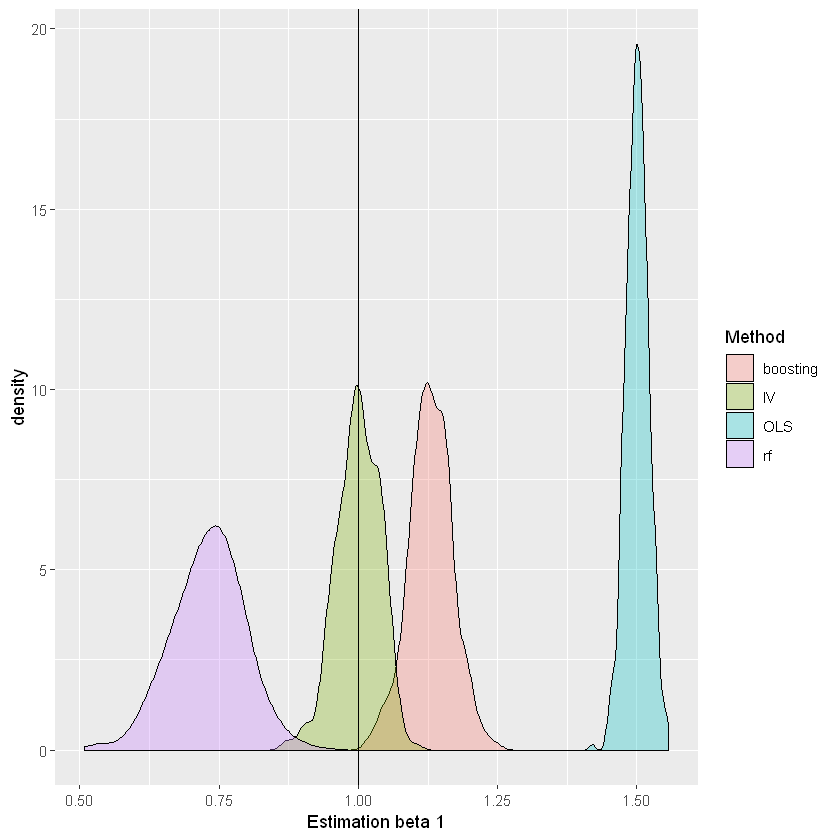

In [20]:
beta1_density_low

## Case B <a class="anchor" id="B"></a>

Case B simulates exactly what is proposed by Lennon et al (2021). Here, the DGP for $x_1$ follows $x_1=g_x(z, \varepsilon_c) = \sum_{i=1}^{7} z_i + \varepsilon_c$, where $|z|=7$ is a set of strong individual instruments. The only variation made in this project is that I set the correlation between the set of instruments to $\sqrt(0.5) \approx 0.7$, so the variance-covariance matrix $\sum_z$ is such that Cov$(z_i, z_j)=0.7$ and Var$(z_i)=1 \; \forall \; i\neq j.$ The code below follows exactly what stated before in the baseline DGP section. Nonlinear methods here will also expect to perform worst than OLS , meaning that it is also a linear scenario thus with several covariates that add more complexity in comparison to the Case A scenario of the present project. 

The tunning parameters for tree based methods are stablished as follows: 
* Random Forest: $mrqt=p/3$, where $p$ is the number of regressors, in this case, 7 instruments; number of trees=100, importance=True.
* Boosted trees: $\lambda=0.1$, $B=100$, $d=4$, $distribution=gaussian$, as the endogenous regressor is a continous variable.

---
<span style="color:coral">**NOTE**:</span> The authors do not provide their code of the simulation study, so the replication conducted in this project follows the explicit specifications provided within the paper.

---

In [21]:
dgp_medium <- function(N, P, cov.mat, beta_0, beta_1, beta_2){
  err_c=rnorm(N, 0, 1)
  theta=runif(N, -1, 1)
  Z=data.frame(mvrnorm(N, rep(0,P), cov.mat))
  colnames(Z) <- c("z1", "z2", "z3", "z4", "z5", "z6", "z7")
  x2= 1 + err_c
  x1= pi_1*Z$z1 + pi_2*Z$z2 + pi_3*Z$z3 + pi_4*Z$z4 + pi_5*Z$z5 + 
      pi_6*Z$z6 + pi_7*Z$z7 + err_c
  y= beta_0 + beta_1*x1 + beta_2*x2 + theta
  data_sim <- data.frame("y"=y,"x1"=x1, "x2"=x2, "z"=Z)
  return(data_sim)
}

set.seed(48)
num_sim <- 500
n <- 1000 
p <- 7  
b.0 <- 1
b.1 <- 1
b.2 <- 1
pi_1 <- pi_2 <- pi_3 <- pi_4 <- pi_5 <- pi_6 <- pi_7 <- 1

cov.mat <- diag(7)
cov.mat[outer(1:7, 1:7, function(i,j) i!=j)] <- sqrt(0.5)

#matrices to storage coefficients
ols_train_error_m <- rep(NA,num_sim)
ols_test_error_m <- rep(NA,num_sim)
iv_train_error_m <- rep(NA,num_sim)
iv_test_error_m <- rep(NA,num_sim)
two_sls_train_error_m <- rep(NA,num_sim)
two_sls_test_error_m <- rep(NA,num_sim)
rf_train_error_m <- rep(NA,num_sim)
rf_test_error_m <- rep(NA,num_sim)
boost_train_error_m <- rep(NA, num_sim)
boost_test_error_m <- rep(NA, num_sim)

#matrices to get coefficients
c.1.1_m <- rep(NA,num_sim)
c.1.2_m <- rep(NA,num_sim)
c.2.1_m <- rep(NA,num_sim)
c.2.2_m <- rep(NA,num_sim)
c.3.1_m <- rep(NA,num_sim)
c.3.2_m <- rep(NA,num_sim)
c.4.1_m <- rep(NA,num_sim)
c.4.2_m <- rep(NA,num_sim)


s.1.2_m <- rep(NA,num_sim)
s.2.2_m <- rep(NA,num_sim)
s.3.2_m <- rep(NA,num_sim)
s.4.2_m <- rep(NA,num_sim)


for(i in 1:num_sim){
    set.seed(i)
    data <- dgp_medium(N = n, P= p, cov.mat=cov.mat, beta_0=b.0, beta_1=b.1, beta_2=b.2) 
    colnames(data) <- c("y", "x1", "x2", "z1", "z2", "z3", "z4", "z5", "z6", "z7")
  
  
    smp_size <- floor(0.7 * nrow(data))
    train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  
    train_data <- data[train_ind, ]
    test_data <- data[-train_ind, ]
  
      
    naive_ols <- lm(y ~ x1, data = data) 
    c.m1 <- coefficients(naive_ols)
  
    s.m1 <- summary((lm(y ~ x1, data = data)))$coefficients[2, 2]

      
    naive_ols_train <- lm(y ~ x1, data = train_data)
    train_MSE_OLS = mean(naive_ols_train$residuals^2)
    ols_train_error_m[i] <- train_MSE_OLS

    test_mse_ols <- test_mse(test_data, lm(y ~ x1, data = test_data))
    ols_test_error_m[i] <- test_mse_ols

     
    iv <- ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = data)
    c.m2 <- coefficients(iv)
    s.m2 <- summary(ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = data))$coefficients[2, 2]

      
    iv_train <- ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = train_data)
    train_mse_iv <- mean(iv_train$residuals^2)
    iv_train_error_m[i] <- train_mse_iv 

    test_mse_iv <- test_mse(test_data, ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = test_data))
    iv_test_error_m[i] <- test_mse_iv

    ols_1st <- lm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, data=data)
    xhat_ols <- predict(ols_1st)
    ols_2nd <- lm(y ~ xhat_ols, data = data)

    ols_1st_train <- lm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, data=train_data)
    xhat_ols_test <- predict(ols_1st_train, newdata = test_data)

    train_mse_2sls <- mean(ols_1st_train$residuals^2)
    test_mse_2sls <- mean((xhat_ols_test - test_data$x1)^2)
    two_sls_train_error_m[i] <- train_mse_2sls
    two_sls_test_error_m[i] <- test_mse_2sls

    trees <- 100

    rf_1st =randomForest(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, 
                         importance=TRUE, 
                         data=train_data, 
                         ntree=trees)
    
    xhat <- predict(rf_1st) #OOB predictions
    c.m3 = coefficients(lm(y ~ xhat, data = train_data))
    s.m3 <- summary(lm(y ~ xhat, data = train_data))$coefficients[2, 2]

    xhat_test <- predict(rf_1st, newdata = test_data)
    train_mse_rf <- mean(rf_1st$mse) 
    test_mse_rf <- mean((xhat_test - test_data$x1)^2) 

    rf_train_error_m[i] <-train_mse_rf
    rf_test_error_m[i] <- test_mse_rf

    boost_1st_m <- gbm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, data=train_data, distribution = "gaussian", 
                   n.trees = trees, interaction.depth = 4)
    xhat_boost <- predict(boost_1st_m, n.trees=trees)
    c.m4 = coefficients(lm(y ~ xhat_boost, data = train_data))
    s.m4 <- summary(lm(y ~ xhat_boost, data = train_data))$coefficients[2, 2]

    xhat_boost_test <- predict(boost_1st_m, newdata = test_data, n.trees = trees)
    train_mse_b <- mean(boost_1st_m$train.error) 
    test_mse_b <- mean((xhat_boost_test - test_data$x1)^2) 

    boost_train_error_m[i] <-train_mse_b
    boost_test_error_m[i] <- test_mse_b

    c.1.1_m[i] = c.m1[1]
    c.1.2_m[i] = c.m1[2]  
    c.2.1_m[i] = c.m2[1]
    c.2.2_m[i] = c.m2[2]
    c.3.1_m[i] = c.m3[1]
    c.3.2_m[i] = c.m3[2]
    c.4.1_m[i] = c.m4[1]
    c.4.2_m[i] = c.m4[2]

    s.1.2_m[i] <- s.m1
    s.2.2_m[i] <- s.m2
    s.3.2_m[i] <- s.m3
    s.4.2_m[i] <- s.m4
  
}

coef_m <- cbind(c.1.1_m, c.1.2_m, c.2.1_m, c.2.2_m, c.3.1_m, c.3.2_m, c.4.1_m, c.4.2_m)
mi.coef_m <- coef_m[,c(2,4,6, 8)]
colnames(mi.coef_m) <- c("OLS", "IV", "rf", "boosting")
mi.coef_m <- melt(mi.coef_m)
mi.coef_m <- mi.coef_m[,-1]

beta1_density_medium <- ggplot(mi.coef_m, aes(x=value, fill=X2)) + geom_density(alpha=.3) +
                 xlab("Estimation beta 1")
beta1_density_medium <- beta1_density_medium + geom_vline(xintercept = 1) + 
                guides(fill=guide_legend(title="Method"))

b1<-mean(c.1.2_m)
b2<-mean(c.2.2_m)
b3<-mean(c.3.2_m)
b4<-mean(c.4.2_m)

b5<-mean(s.1.2_m)
b6<-mean(s.2.2_m)
b7<-mean(s.3.2_m)
b8<-mean(s.4.2_m)

b9<-b1-1
b10<-b2-1
b11<-b3-1
b12<-b4-1

I double check the correlation betweeen the set of instruments and the endogenous variable with the following correlation map, where it is shown that the seven instruments are positively correlated with each other and also correlated with $x_1$. I also draw a pairs graph in order to show that the variables' relation is linear rather than non-linear.

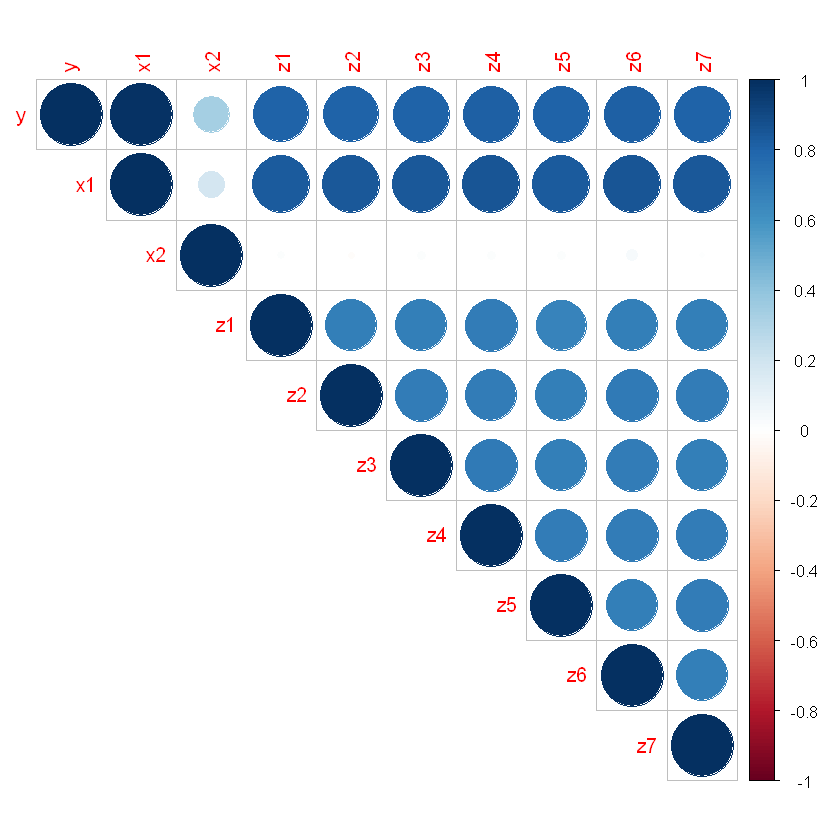

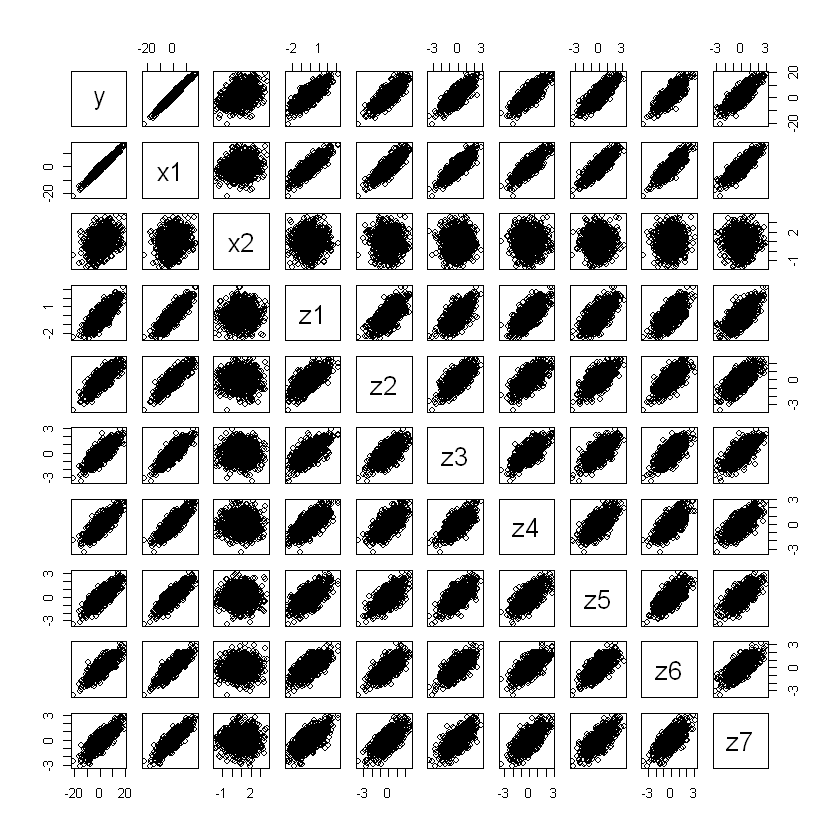

In [25]:
cor <- cor(data)
corrplot(cor, type = "upper")

pairs(data)

For running first stage predictions, Case B estimates a boosted tree model with 100 trees and a tunning parameter of 0.1. In order to verify that the number of trees is optimal, I plot the squared error loss function against the number of iterations (i.e., number of trees) to establish the optimal number of trees for a shrinking parameter of 0.1 and a split of 4. In the graph below, the blue dashed line shows what is the optimal number of iterations according to the metric and validation procedure used and here the optimum is reached before 100 trees, so the model is well established with 100 trees for estimation.  

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.


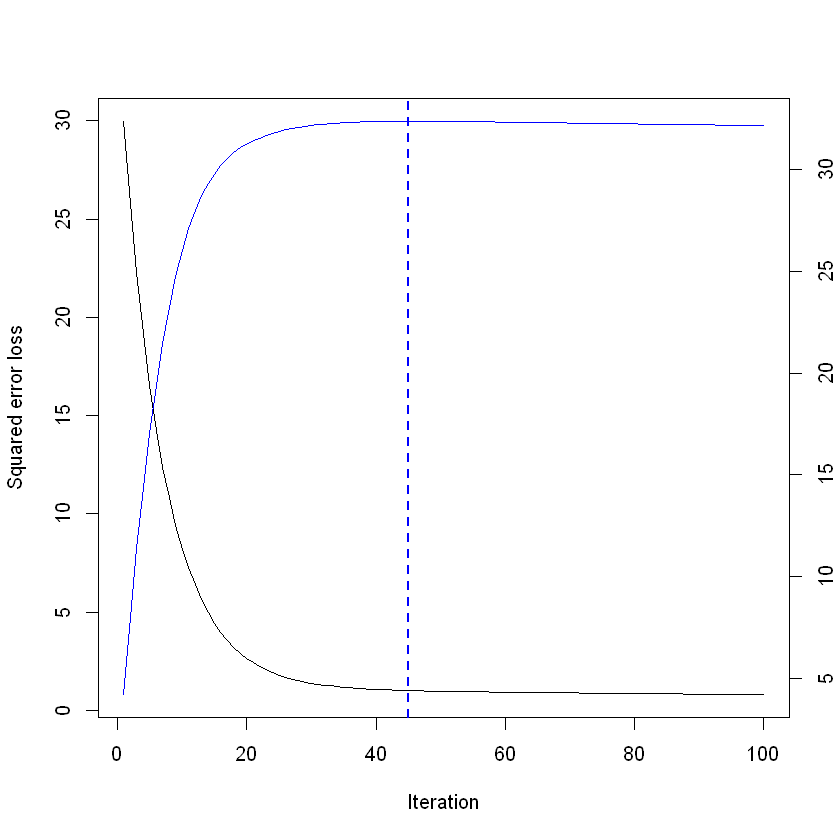

[1] 45
attr(,"smoother")
Call:
loess(formula = object$oobag.improve ~ x, enp.target = min(max(4, 
    length(x)/10), 50))

Number of Observations: 100 
Equivalent Number of Parameters: 8.32 
Residual Standard Error: 0.1246

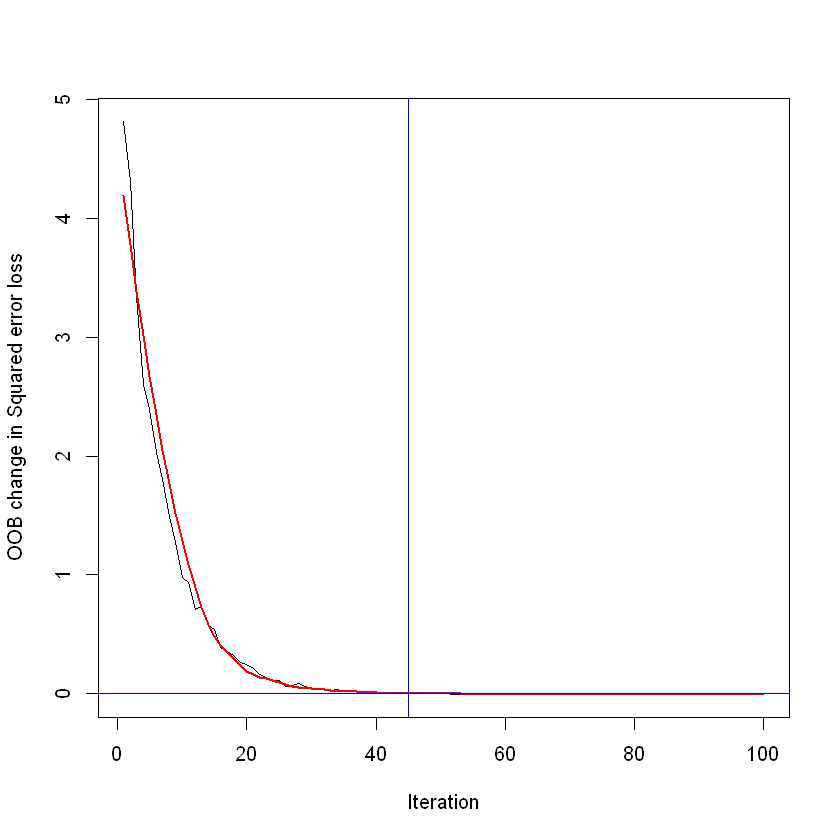

In [26]:
gbm.perf(boost_1st_m, plot.it=T, oobag.curve=T, method='OOB')

## Case B - Results <a class="anchor" id="RB"></a>

**First stage prediction**

For scenario B, adding more regressors to the model could mean a relatively better performance of tree based methods over linear models. Regarding this, I here add a plot that shows the mechanism behind random forest, one of the tree based methods applied in the project. Random forest assigns a variable importance to the regressors of the estimated model. The left panel of the variable importance graph shows how much the MSE will increase if a variable is assigned values by random permutation. For example, if there is a variation in $z_7$, the MSE will increase by approximately 16% on average. On the other hand, Node purity is measured by Gini Index. In this case, the most important variable for estimating $\hat{x}_1$ is $z_7$, followed by $z_4$, $z_6$ and so on. 


Results show that OLS still performs better in terms of test MSE than non-linear methods, even if the set of variables is larger than scenario A, which could add variable selection attributes to the model. Table_1_m summarises the test MSE for each method, where IV shows a MSE of 1.0074, rf 1.4011 and boosting 1.3906. On the other hand, I plot a box plot to display the variation of the test MSE to further compare the performance of the models. In the graph below, one can see that IV performs better, but there are some outlier observations where IV overlaps with the other nonlinear methods.

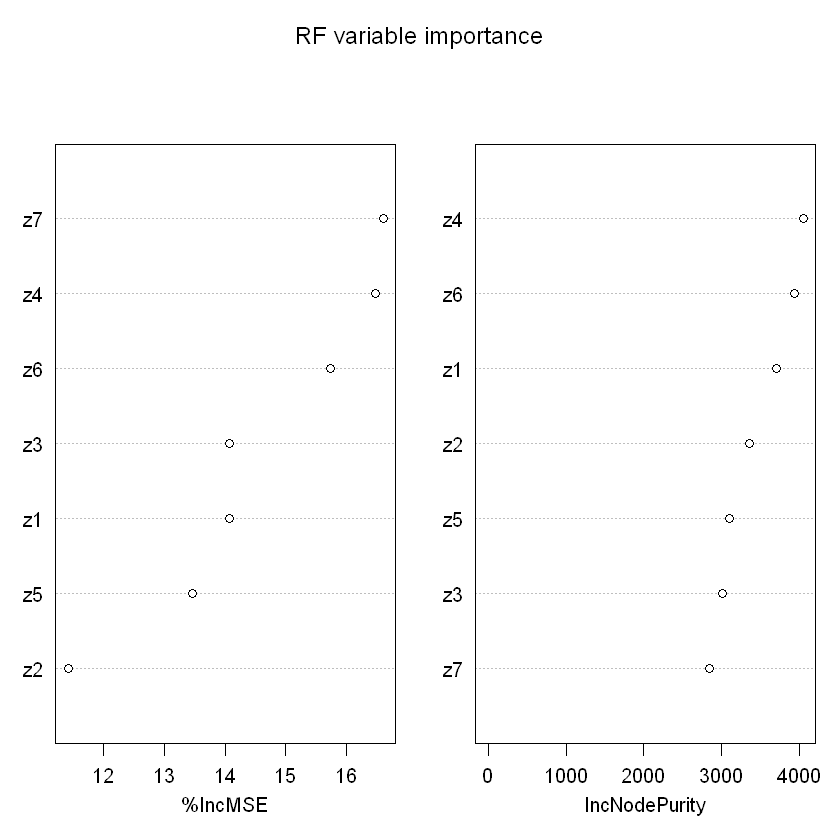

In [30]:
varImpPlot(rf_1st, sort = T, main="RF variable importance")

In [27]:
table_1_m<-matrix(c(mean(two_sls_train_error_m), mean(two_sls_test_error_m), 
                    mean(rf_train_error_m), mean(rf_test_error_m), mean(boost_train_error_m), 
                    mean(boost_test_error_m)), ncol=2, byrow=T)
colnames(table_1_m)<-c("train error", "test error")
rownames(table_1_m)<-c("2SLS", "RF", "Boosting")
round(table_1_m, digits = 4)

,train error,test error
2SLS,0.9905,1.0074
RF,1.8348,1.4011
Boosting,3.1040,1.3906


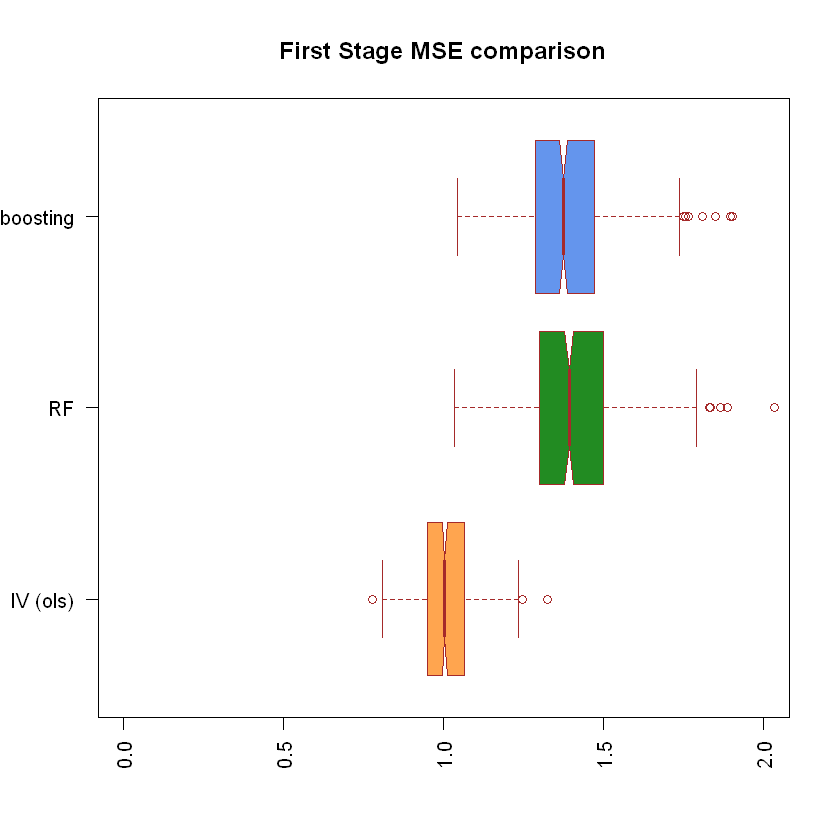

In [31]:
boxplot(two_sls_test_error_m, rf_test_error_m, boost_test_error_m,
        main = "First Stage MSE comparison",
        at = c(1,2,3),
        names = c("IV (ols)", "RF", "boosting"),
        las = 2,
        col = c("tan1","forestgreen", "cornflowerblue"),
        border = "brown",
        horizontal = TRUE,
        notch = TRUE,
        ylim = c(0, 2)
)

**Second stage performance**

Here, the results are very similar to the ones found in Lennon et al (2021). The authors find the following estimates (std.erros in parenthesis): naive OLS 1.038 (0.007); IV 1.001 (0.017); boosted trees 1.008 (0.007); and random forest 1.071 (0.008). Table_2_m shows the performance of first stage prediction of the methods applied in this specific project: OLS 1.027 (0.006); IV 1.001 (0.006), boosted trees 1.009 (0.011) and random forest 1.061 (0.014). 

This replication supports the argument of Lennon et al (2021) that IV produces again the less biased result, followed by boosted trees, OLS and random forest. According to the authors, random forest seems to perform the worst among tree based methods, even generating worst results than a naive OLS for the second stage. 

In [28]:
table_2_m <- matrix(c(b1, b5, b9, b2, b6, b10, b3, b7, b11, b4, b8, b12), ncol=3, byrow=T)
colnames(table_2_m) <- c("Estimate beta 1", "Std. Error", "Bias")
rownames(table_2_m) <- c("ols", "IV", "RF", "Boosting")
round(table_2_m, digits = 4)

,Estimate beta 1,Std. Error,Bias
ols,1.0271,0.0059,0.0271
IV,1.0007,0.0060,0.0007
RF,1.0605,0.0144,0.0605
Boosting,1.0092,0.0118,0.0092


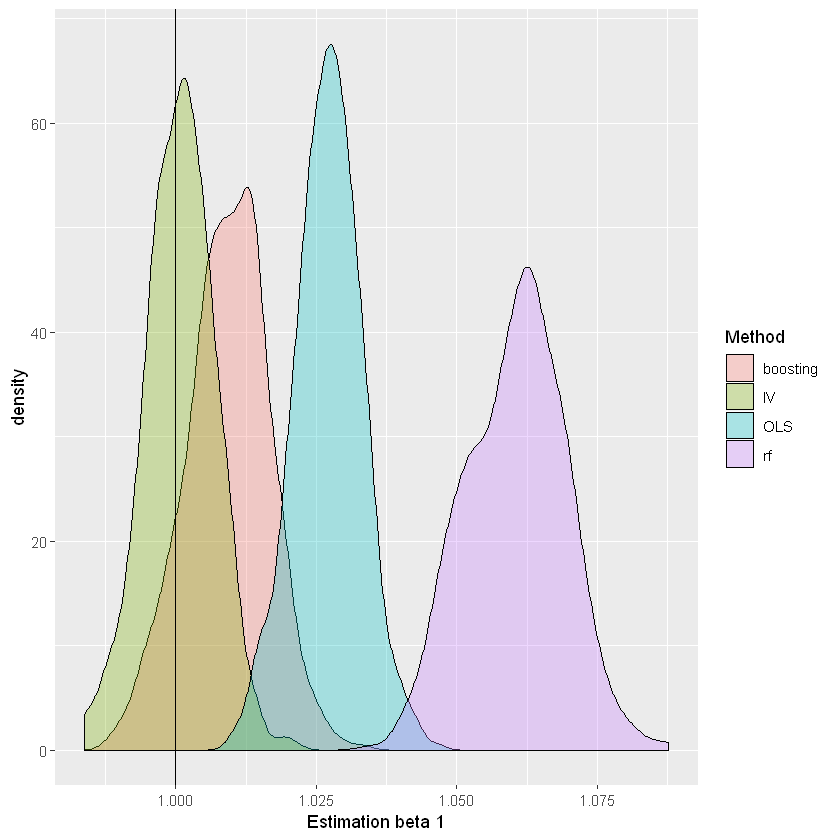

In [29]:
beta1_density_medium

## Case C <a class="anchor" id="C"></a>

Recall that boosted trees have 3 tuning parameters: 1) The number of trees used for building the model $B$; 2) the shrinking parameter $\lambda$, which is a positive number that controls the rate at which the boosting learns; and 3) the number $d$ splits in each tree, which controls the complexity of the boosted trees. Case C explores how sensitive the results for boosted trees are to different specifications of these tunning parameters. 

For doing so, I lower the shrinking parameter $\lambda$ from 0.1 to 0.01 in order to increase the rate at which the boosted trees learn. According to Elith et al (2008), the learning rate establishes the number of trees needed to be used for boosted trees estimation, since in general a lower learning rate requires a larger amount of trees. I then compare the performance of boosted trees for the first stage estimation, and explore whether a better prediction of $\hat{x}$ helps to reduce bias in the second stage.

For this specific case then, the DGP and the model specifications are the same as in Case B, with the only difference that the tuning parameters of boosted trees are set to $\lambda=0.01$ and $B=500$. 

In [45]:
dgp_medium <- function(N, P, cov.mat, beta_0, beta_1, beta_2){
  err_c=rnorm(N, 0, 1)
  theta=runif(N, -1, 1)
  Z=data.frame(mvrnorm(N, rep(0,P), cov.mat))
  colnames(Z) <- c("z1", "z2", "z3", "z4", "z5", "z6", "z7")
  x2= 1 + err_c
  x1= pi_1*Z$z1 + pi_2*Z$z2 + pi_3*Z$z3 + pi_4*Z$z4 + pi_5*Z$z5 + 
    pi_6*Z$z6 + pi_7*Z$z7 + err_c
  y= beta_0 + beta_1*x1 + beta_2*x2 + theta
  data_sim <- data.frame("y"=y,"x1"=x1, "x2"=x2, "z"=Z)
  return(data_sim)
}


num_sim <- 500
n <- 1000 
p <- 7 
b.0 <- 1
b.1 <- 1
b.2 <- 1
pi_1 <- pi_2 <- pi_3 <- pi_4 <- pi_5 <- pi_6 <- pi_7 <- 1

cov.mat <- diag(7)
cov.mat[outer(1:7, 1:7, function(i,j) i!=j)] <- sqrt(0.5)

ols_train_error_m_s <- rep(NA,num_sim)
ols_test_error_m_s <- rep(NA,num_sim)
iv_train_error_m_s <- rep(NA,num_sim)
iv_test_error_m_s <- rep(NA,num_sim)
two_sls_train_error_m_s <- rep(NA,num_sim)
two_sls_test_error_m_s <- rep(NA,num_sim)
rf_train_error_m_s <- rep(NA,num_sim)
rf_test_error_m_s <- rep(NA,num_sim)
boost_train_error_m_s <- rep(NA, num_sim)
boost_test_error_m_s <- rep(NA, num_sim)

c.1.1_m_s <- rep(NA,num_sim)
c.1.2_m_s <- rep(NA,num_sim)
c.2.1_m_s <- rep(NA,num_sim)
c.2.2_m_s <- rep(NA,num_sim)
c.3.1_m_s <- rep(NA,num_sim)
c.3.2_m_s <- rep(NA,num_sim)
c.4.1_m_s <- rep(NA,num_sim)
c.4.2_m_s <- rep(NA,num_sim)

s.1.2_m_s <- rep(NA,num_sim)
s.2.2_m_s <- rep(NA,num_sim)
s.3.2_m_s <- rep(NA,num_sim)
s.4.2_m_s <- rep(NA,num_sim)


set.seed(48)
for(i in 1:num_sim){
  set.seed(i)
  data <- dgp_medium(N = n, P= p, cov.mat=cov.mat, beta_0=b.0, beta_1=b.1, beta_2=b.2) 
  colnames(data) <- c("y", "x1", "x2", "z1", "z2", "z3", "z4", "z5", "z6", "z7")
  
  #partitioning the data
  smp_size <- floor(0.7 * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  
  train_data <- data[train_ind, ]
  test_data <- data[-train_ind, ]
  
  #naive OLS regression
  naive_ols <- lm(y ~ x1, data = data) 
  c.m1 <- coefficients(naive_ols)
  s.m1 <- summary((lm(y ~ x1, data = data)))$coefficients[2, 2]
  
  #mse for the ols
  naive_ols_train <- lm(y ~ x1, data = train_data)
  train_MSE_OLS = mean(naive_ols_train$residuals^2)
  ols_train_error_m_s[i] <- train_MSE_OLS
  
  test_mse_ols <- test_mse(test_data, lm(y ~ x1, data = test_data))
  ols_test_error_m_s[i] <- test_mse_ols
  
  # IV model
  iv <- ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = data)
  c.m2 <- coefficients(iv)
  s.m2 <- summary(ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = data))$coefficients[2, 2]
  
  #IV mse
  iv_train <- ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = train_data)
  train_mse_iv <- mean(iv_train$residuals^2)
  iv_train_error_m_s[i] <- train_mse_iv 
  
  test_mse_iv <- test_mse(test_data, ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = test_data))
  iv_test_error_m_s[i] <- test_mse_iv
  
  ols_1st <- lm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, data=data)
  xhat_ols <- predict(ols_1st)
  ols_2nd <- lm(y ~ xhat_ols, data = data)
  
  ols_1st_train <- lm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, data=train_data)
  xhat_ols_test <- predict(ols_1st_train, newdata = test_data)
  
  train_mse_2sls <- mean(ols_1st_train$residuals^2)
  test_mse_2sls <- mean((xhat_ols_test - test_data$x1)^2)
  two_sls_train_error_m_s[i] <- train_mse_2sls
  two_sls_test_error_m_s[i] <- test_mse_2sls
  

  trees <- 500
  
  rf_1st =randomForest(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, 
                       mtry=p/3, 
                       importance=TRUE, 
                       data=train_data, 
                       ntree=trees)
    
  xhat <- predict(rf_1st) 
  c.m3 = coefficients(lm(y ~ xhat, data = train_data))
  s.m3 <- summary(lm(y ~ xhat, data = train_data))$coefficients[2, 2]
  
  xhat_test <- predict(rf_1st, newdata = test_data)
  train_mse_rf <- mean(rf_1st$mse) 
  test_mse_rf <- mean((xhat_test - test_data$x1)^2) 
  
  rf_train_error_m_s[i] <-train_mse_rf
  rf_test_error_m_s[i] <- test_mse_rf
  
  #boosting model
  boost_1st_ms <- gbm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, 
                   data=train_data, 
                   distribution = "gaussian", 
                   n.trees = trees, 
                   interaction.depth = 4,
                   shrinkage = 0.01)
  
  xhat_boost <- predict(boost_1st_ms, n.trees=trees)
  c.m4 = coefficients(lm(y ~ xhat_boost, data = train_data))
  s.m4 <- summary(lm(y ~ xhat_boost, data = train_data))$coefficients[2, 2]
  
  xhat_boost_test <- predict(boost_1st_ms, newdata = test_data, n.trees = trees)
  train_mse_b <- mean(boost_1st_ms$train.error) 
  test_mse_b <- mean((xhat_boost_test - test_data$x1)^2) 
  
  boost_train_error_m_s[i] <-train_mse_b
  boost_test_error_m_s[i] <- test_mse_b
  
  c.1.1_m_s[i] = c.m1[1]
  c.1.2_m_s[i] = c.m1[2]  
  c.2.1_m_s[i] = c.m2[1]
  c.2.2_m_s[i] = c.m2[2]
  c.3.1_m_s[i] = c.m3[1]
  c.3.2_m_s[i] = c.m3[2]
  c.4.1_m_s[i] = c.m4[1]
  c.4.2_m_s[i] = c.m4[2]
  
  s.1.2_m_s[i] <- s.m1
  s.2.2_m_s[i] <- s.m2
  s.3.2_m_s[i] <- s.m3
  s.4.2_m_s[i] <- s.m4
  
  
}

coef_m_s <- cbind(c.1.1_m_s, c.1.2_m_s, c.2.1_m_s, c.2.2_m_s, c.3.1_m_s, c.3.2_m_s, c.4.1_m_s, c.4.2_m_s)
mi.coef_m_s <- coef_m_s[,c(2,4,6,8)]
colnames(mi.coef_m_s) <- c("OLS", "IV", "rf", "boosting")
mi.coef_m_s <- melt(mi.coef_m_s)
mi.coef_m_s <- mi.coef_m_s[,-1]

beta1_density_medium_s <- ggplot(mi.coef_m_s, aes(x=value, fill=X2)) + geom_density(alpha=.3) +
  xlab("Estimation beta 1")
beta1_density_medium_s <- beta1_density_medium_s + geom_vline(xintercept = 1) + 
  guides(fill=guide_legend(title="Method"))


k1<-mean(c.1.2_m_s)
k2<-mean(c.2.2_m_s)
k3<-mean(c.3.2_m_s)
k4<-mean(c.4.2_m_s)

k5<-mean(s.1.2_m_s)
k6<-mean(s.2.2_m_s)
k7<-mean(s.3.2_m_s)
k8<-mean(s.4.2_m_s)

k9<-k1-1
k10<-k2-1
k11<-k3-1
k12<-k4-1


Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

The following graphs show the convergence of the squared error loss function for a shrinking parameter of 0.01. Here, less than 400 trees assure that the minium of the mse is reached, so a parameter of $B=500$ is correct for tuning the boosted model.

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.


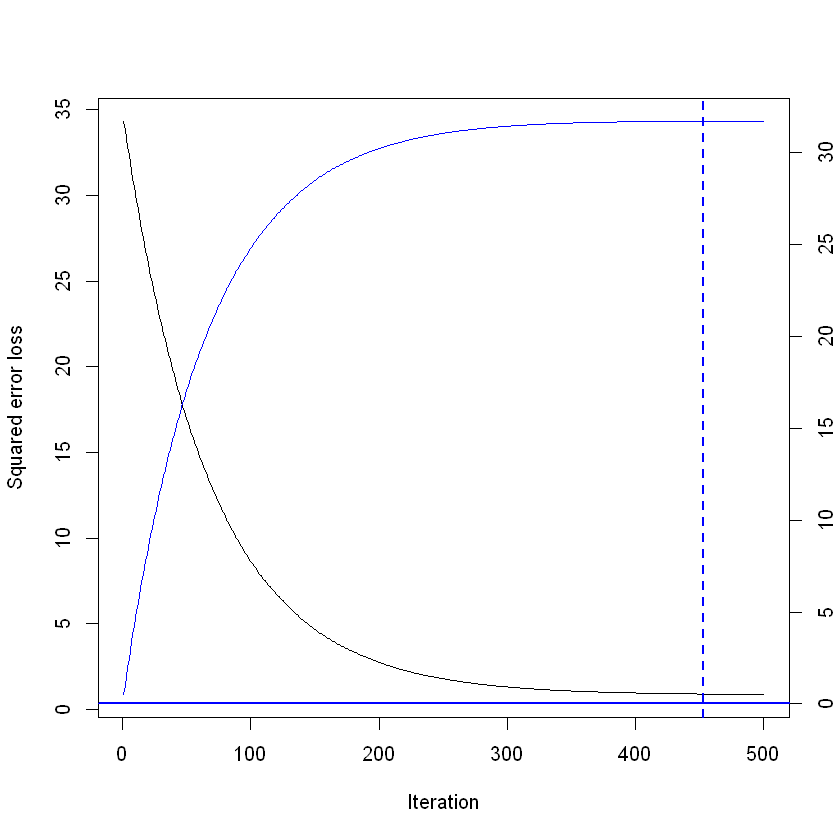

[1] 453
attr(,"smoother")
Call:
loess(formula = object$oobag.improve ~ x, enp.target = min(max(4, 
    length(x)/10), 50))

Number of Observations: 500 
Equivalent Number of Parameters: 39.85 
Residual Standard Error: 0.008394

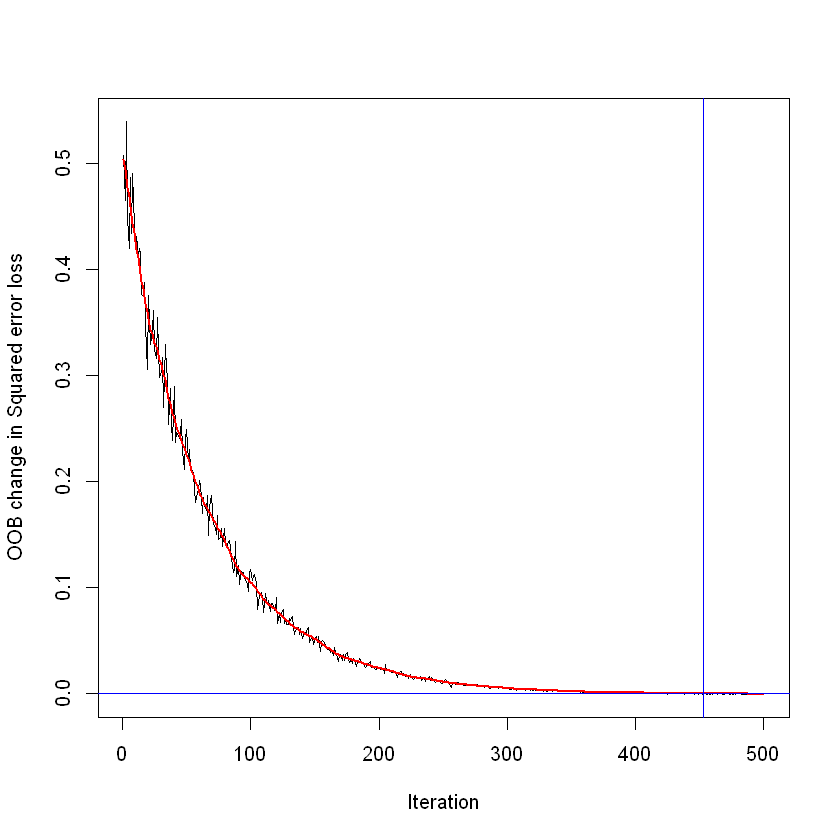

In [47]:
gbm.perf(boost_1st_ms, plot.it=T, oobag.curve=T, method='OOB')

Since I use the same number of trees for both random forest and boosting, I here make sure that 500 trees are also enough to optimize the error of the random forest model. The following graphs shows that indeed, even 100 trees will optimize the error of a random forest prediction of $\hat{x}$.

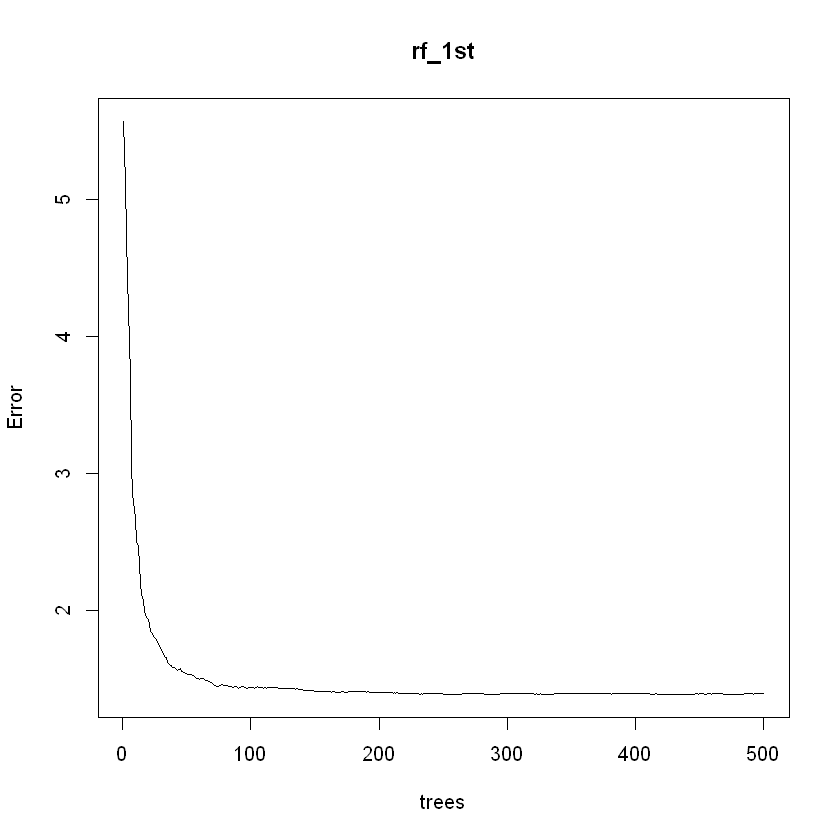

In [48]:
plot(rf_1st)

## Case C - Results <a class="anchor" id="RC"></a>

**First stage prediction**

Both the box plot and Table_1_m_s shows that decreasing the shrinking parameter for the boosted tree decreases the test mse from 1.4728 (Case B) to 1.3222 (Case C). That means, on average, the boosted tree now is making a better estimation of $\hat{x}$. By consequence, since I am using the same amount of trees for both random forest and boosting, a higher number of trees also increases the prediction power of random forest by decreasing the related test mse to 1.3687. Tree based methods still perform worse than OLS, but the research question here is whether a better prediction of $\hat{x}$ of random forest and boosting contributes to a reduction in bias in the second stage.

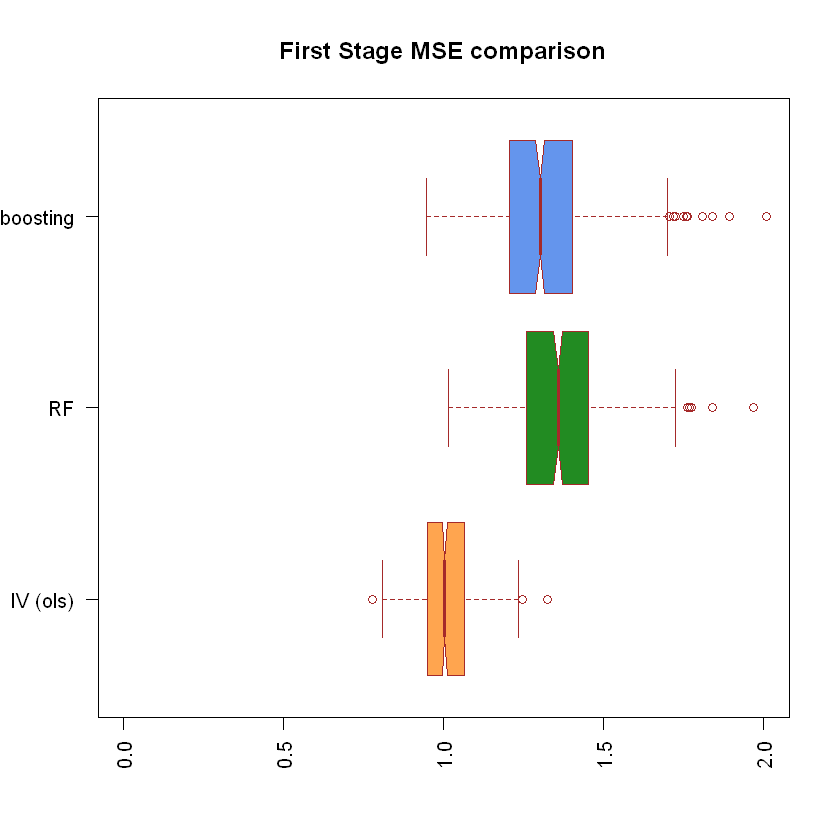

In [51]:
boxplot(two_sls_test_error_m_s, rf_test_error_m_s, boost_test_error_m_s,
        main = "First Stage MSE comparison",
        at = c(1,2,3),
        names = c("IV (ols)", "RF", "boosting"),
        las = 2,
        col = c("tan1","forestgreen", "cornflowerblue"),
        border = "brown",
        horizontal = TRUE,
        notch = TRUE,
        ylim = c(0, 2)
)

In [49]:
table_1_m_s<-matrix(c(mean(two_sls_train_error_m_s), mean(two_sls_test_error_m_s), 
                      mean(rf_train_error_m_s), mean(rf_test_error_m_s), mean(boost_train_error_m_s), 
                      mean(boost_test_error_m_s)), ncol=2, byrow=T)
colnames(table_1_m_s)<-c("train error", "test error")
rownames(table_1_m_s)<-c("2SLS", "RF", "Boosting")
round(table_1_m_s, digits = 4)

,train error,test error
2SLS,0.9905,1.0074
RF,1.4957,1.3687
Boosting,5.7579,1.3222


**Second stage performance**

The results for the second stage suggest that, even if the prediction in the first stage is closer to the actual values of $x_1$, nonlinear methods still present biased estimations of the true parameter of the endogenous regressor. Here, random forest has a bias of 0.0631 and boosting 0.0246. What is surprising is that actually the bias is relatively larger than Case B for both tree based methods and here boosted trees present almost the same bias as the naive OLS, where the naive OLS bias is 0.0271. 

One could argue as a small conclusion to this excercise that a better prediction of the tree based methods does not necessarily improve estimations of endogenous variables when these predictions are used as inputs in the second stage. As for the Lennon et al (2021) results, where they find that boosted trees have less bias than the naive OLS procedure, one could argue after this simulation that this result is not conclusive and might depend on the tuning parameters of the models.

In [50]:
table_2_m_s <- matrix(c(k1, k5, k9, k2, k6, k10, k3, k7, k11, k4, k8, k12), ncol=3, byrow=T)
colnames(table_2_m_s) <- c("Estimate beta 1", "Std. Error", "Bias")
rownames(table_2_m_s) <- c("ols", "IV", "RF", "Boosting")
round(table_2_m_s, digits = 4)

,Estimate beta 1,Std. Error,Bias
ols,1.0271,0.0059,0.0271
IV,1.0007,0.0060,0.0007
RF,1.0631,0.0143,0.0631
Boosting,1.0246,0.0124,0.0246


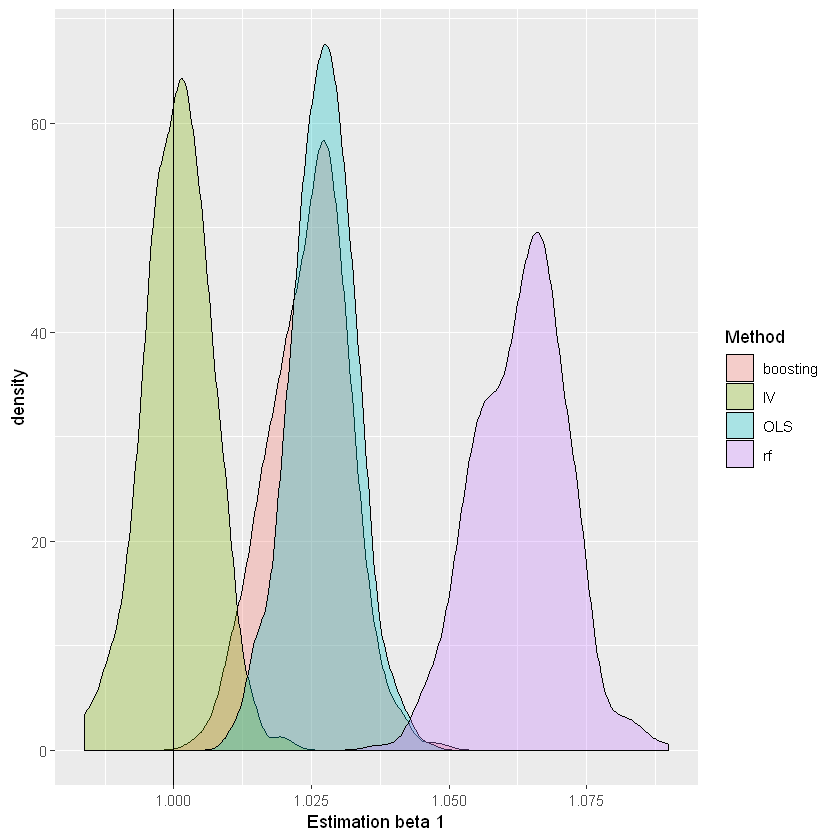

In [52]:
beta1_density_medium_s 

## Case D <a class="anchor" id="D"></a>

In an own extension to their analysis, I change the variance-covariance matrix proposed by Lennon et al (2021) to make a set of instruments that are uncorrelated to each other. Thus, $\sum_z$ such that Cov$(z_i, z_j)=0$ and Var$(z_i)=1 \; \forall \; i\neq j.$ The idea is to check whether the results are also sensitive to how the instruments are correlated to each other and how nonlinear methods then perform. 

In [53]:
set.seed(48)

dgp_medium_c <- function(N, P, cov.mat, beta_0, beta_1, beta_2){
  err_c=rnorm(N, 0, 1)
  theta=runif(N, -1, 1)
  Z=data.frame(mvrnorm(N, rep(0,P), cov.mat))
  colnames(Z) <- c("z1", "z2", "z3", "z4", "z5", "z6", "z7")
  x2= 1 + err_c
  x1= pi_1*Z$z1 + pi_2*Z$z2 + pi_3*Z$z3 + pi_4*Z$z4 + pi_5*Z$z5 + 
    pi_6*Z$z6 + pi_7*Z$z7 + err_c
  y= beta_0 + beta_1*x1 + beta_2*x2 + theta
  data_sim <- data.frame("y"=y,"x1"=x1, "x2"=x2, "z"=Z)
  return(data_sim)
}


num_sim <- 500
n <- 1000 
p <- 7  
b.0 <- 1
b.1 <- 1
b.2 <- 1
pi_1 <- pi_2 <- pi_3 <- pi_4 <- pi_5 <- pi_6 <- pi_7 <- 1

cov.mat <- diag(7)

ols_train_error_m_c <- rep(NA,num_sim)
ols_test_error_m_c <- rep(NA,num_sim)
iv_train_error_m_c <- rep(NA,num_sim)
iv_test_error_m_c <- rep(NA,num_sim)
two_sls_train_error_m_c <- rep(NA,num_sim)
two_sls_test_error_m_c <- rep(NA,num_sim)
rf_train_error_m_c <- rep(NA,num_sim)
rf_test_error_m_c <- rep(NA,num_sim)
boost_train_error_m_c <- rep(NA, num_sim)
boost_test_error_m_c <- rep(NA, num_sim)

c.1.1_m_c <- rep(NA,num_sim)
c.1.2_m_c <- rep(NA,num_sim)
c.2.1_m_c <- rep(NA,num_sim)
c.2.2_m_c <- rep(NA,num_sim)
c.3.1_m_c <- rep(NA,num_sim)
c.3.2_m_c <- rep(NA,num_sim)
c.4.1_m_c <- rep(NA,num_sim)
c.4.2_m_c <- rep(NA,num_sim)

s.1.2_m_c <- rep(NA,num_sim)
s.2.2_m_c <- rep(NA,num_sim)
s.3.2_m_c <- rep(NA,num_sim)
s.4.2_m_c <- rep(NA,num_sim)

set.seed(48)

for(i in 1:num_sim){
  set.seed(i)
  data <- dgp_medium(N = n, P= p, cov.mat=cov.mat, beta_0=b.0, beta_1=b.1, beta_2=b.2) 
  colnames(data) <- c("y", "x1", "x2", "z1", "z2", "z3", "z4", "z5", "z6", "z7")
  
  smp_size <- floor(0.7 * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  
  train_data <- data[train_ind, ]
  test_data <- data[-train_ind, ]
  
  naive_ols <- lm(y ~ x1, data = data) 
  c.m1 <- coefficients(naive_ols)
  s.m1 <- summary((lm(y ~ x1, data = data)))$coefficients[2, 2]
  
  naive_ols_train <- lm(y ~ x1, data = train_data)
  train_MSE_OLS = mean(naive_ols_train$residuals^2)
  ols_train_error_m_c[i] <- train_MSE_OLS
  
  test_mse_ols <- test_mse(test_data, lm(y ~ x1, data = test_data))
  ols_test_error_m_c[i] <- test_mse_ols
  
  iv <- ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = data)
  c.m2 <- coefficients(iv)
  s.m2 <- summary(ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = data))$coefficients[2, 2]
  
  iv_train <- ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = train_data)
  train_mse_iv <- mean(iv_train$residuals^2)
  iv_train_error_m_c[i] <- train_mse_iv 
  
  test_mse_iv <- test_mse(test_data, ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5 + z6 + z7, data = test_data))
  iv_test_error_m_c[i] <- test_mse_iv
  
  ols_1st <- lm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, data=data)
  xhat_ols <- predict(ols_1st)
  ols_2nd <- lm(y ~ xhat_ols, data = data)

  ols_1st_train <- lm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, data=train_data)
  xhat_ols_test <- predict(ols_1st_train, newdata = test_data)
  
  train_mse_2sls <- mean(ols_1st_train$residuals^2)
  test_mse_2sls <- mean((xhat_ols_test - test_data$x1)^2)
  two_sls_train_error_m_c[i] <- train_mse_2sls
  two_sls_test_error_m_c[i] <- test_mse_2sls
  
  trees <- 500
  
  rf_1st =randomForest(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, 
                       mtry=p/3, 
                       importance=TRUE, 
                       data=train_data, 
                       ntree=trees)
    
  xhat <- predict(rf_1st) 
  c.m3 = coefficients(lm(y ~ xhat, data = train_data))
  s.m3 <- summary(lm(y ~ xhat, data = train_data))$coefficients[2, 2]
  
  rf_1st_train =randomForest(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, 
                             mtry=sqrt(p), 
                             importance=TRUE, 
                             data=train_data, 
                             ntree=trees)
    
  xhat_test <- predict(rf_1st, newdata = test_data)
  
  train_mse_rf <- mean(rf_1st_train$mse) 
  test_mse_rf <- mean((xhat_test - test_data$x1)^2) 
  
  rf_train_error_m_c[i] <-train_mse_rf
  rf_test_error_m_c[i] <- test_mse_rf

  boost_1st <- gbm(x1 ~ z1 + z2 + z3 + z4 + z5 + z6 + z7, 
                   data=train_data, 
                   distribution = "gaussian", 
                   n.trees = trees, 
                   interaction.depth = 4, 
                   shrinkage = 0.01)
    
  xhat_boost <- predict(boost_1st, n.trees = trees)
  c.m4 = coefficients(lm(y ~ xhat_boost, data = train_data))
  s.m4 <- summary(lm(y ~ xhat_boost, data = train_data))$coefficients[2, 2]

  xhat_boost_test<-predict(boost_1st, newdata= test_data, n.trees = trees)
  
  train_mse_b <- mean(boost_1st$train.error) 
  test_mse_b <- mean((xhat_boost_test - test_data$x1)^2) 
  
  boost_train_error_m_c[i] <-train_mse_b
  boost_test_error_m_c[i] <- test_mse_b
  
  c.1.1_m_c[i] = c.m1[1]
  c.1.2_m_c[i] = c.m1[2]  
  c.2.1_m_c[i] = c.m2[1]
  c.2.2_m_c[i] = c.m2[2]
  c.3.1_m_c[i] = c.m3[1]
  c.3.2_m_c[i] = c.m3[2]
  c.4.1_m_c[i] = c.m4[1]
  c.4.2_m_c[i] = c.m4[2]
  
  s.1.2_m_c[i] <- s.m1
  s.2.2_m_c[i] <- s.m2
  s.3.2_m_c[i] <- s.m3
  s.4.2_m_c[i] <- s.m4
  
  
}

coef_m_c <- cbind(c.1.1_m_c, c.1.2_m_c, c.2.1_m_c, c.2.2_m_c, c.3.1_m_c, c.3.2_m_c, c.4.1_m_c, c.4.2_m_c)
mi.coef_m_c <- coef_m_c[,c(2,4,6, 8)]
colnames(mi.coef_m_c) <- c("OLS", "IV", "rf", "boosting")
mi.coef_m_c <- melt(mi.coef_m_c)
mi.coef_m_c <- mi.coef_m_c[,-1]

beta1_density_medium_c <- ggplot(mi.coef_m_c, aes(x=value, fill=X2)) + geom_density(alpha=.3) +
  xlab("Estimation beta 1")
beta1_density_medium_c <- beta1_density_medium_c + geom_vline(xintercept = 1) + 
  guides(fill=guide_legend(title="Method"))

h1<-mean(c.1.2_m_c)
h2<-mean(c.2.2_m_c)
h3<-mean(c.3.2_m_c)
h4<-mean(c.4.2_m_c)

h5<-mean(s.1.2_m_c)
h6<-mean(s.2.2_m_c)
h7<-mean(s.3.2_m_c)
h8<-mean(s.4.2_m_c)

h9<-h1-1
h10<-h2-1
h11<-h3-1
h12<-h4-1

## Case D - Results <a class="anchor" id="RD"></a>

The results show that the Lennon et al (2021) findings are also sensitive to changing the correlation between regressors, in this case the set of seven instruments for $x_1$. Consider the variable importance graph of random forest; now, the third instrument is the most important for explaining the variation in the MSE, followed by instrument 6 and so on, which differs from the case of correlated instruments. From the variable importance graphs fTable_1_m_c shows that both the tree based methods perform worse in terms of test MSE as in Case C. In terms of bias, all four methods exhibit a larger bias from the true parameter, and now boosting performs on average worse than OLS and IV (in contrast with Case C), and random forest performs the worst out of the three methods. Summarizing, 2SLS presents a test MSE of 1.0074, rf 2.3118 and boosting 1.8716. In terms of bias, naive ols has a bias of 0.1250, random forest 0.4819, boosting 0.2987 and IV 0.0008. 

,var,rel.inf
z6,z6,16.18871
z4,z4,15.12994
z5,z5,15.09049
z3,z3,14.54087
z1,z1,14.16397
z2,z2,13.31861
z7,z7,11.56741


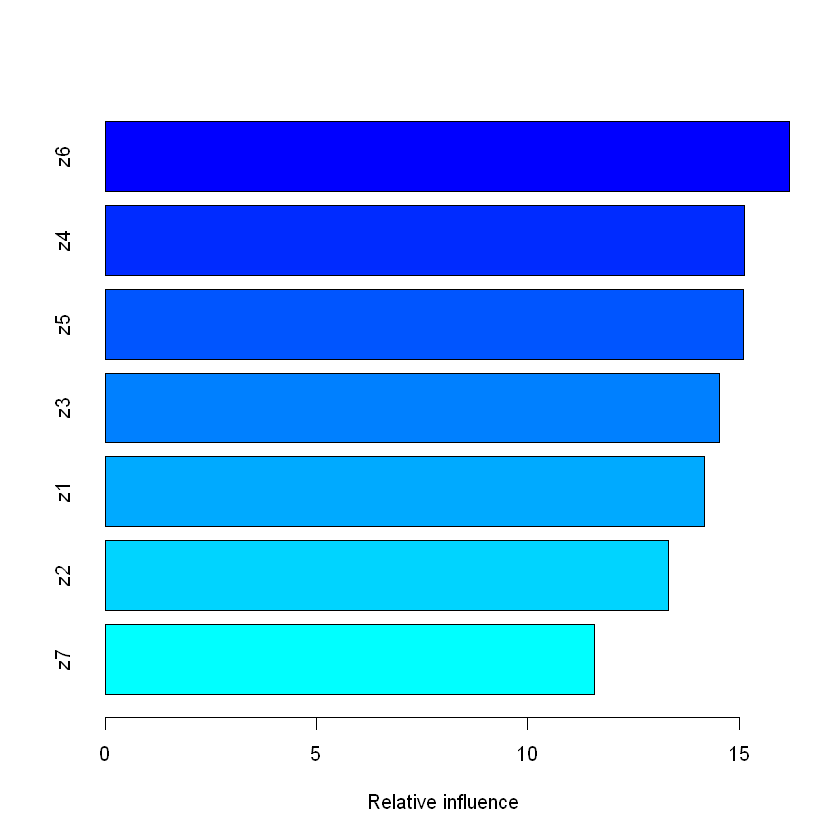

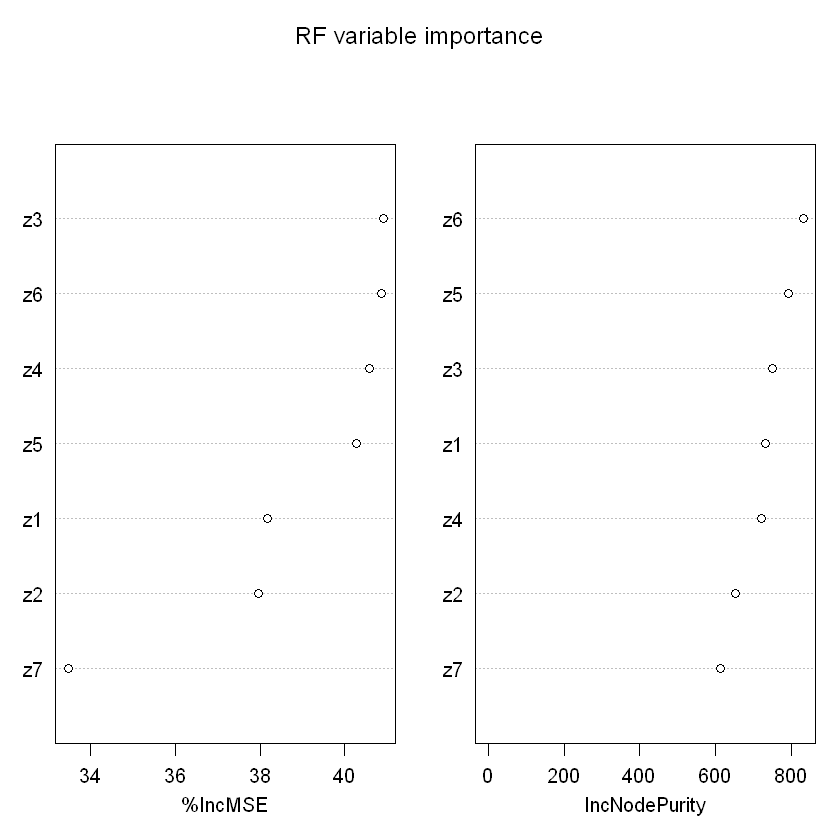

In [54]:
summary(boost_1st) 
varImpPlot(rf_1st, sort = T, main="RF variable importance")

In [55]:
table_1_m_c<-matrix(c(mean(two_sls_train_error_m_c), mean(two_sls_test_error_m_c), 
                    mean(rf_train_error_m_c), mean(rf_test_error_m_c), mean(boost_train_error_m_c), 
                    mean(boost_test_error_m_c)), ncol=2, byrow=T)
colnames(table_1_m_c)<-c("train error", "test error")
rownames(table_1_m_c)<-c("2SLS", "RF", "Boosting")
round(table_1_m_c, digits = 4)

,train error,test error
2SLS,0.9905,1.0074
RF,2.4070,2.3118
Boosting,3.0772,1.8716


In [56]:
table_2_m_c <- matrix(c(h1, h5, h9, h2, h6, h10, h3, h7, h11, h4, h8, h12), ncol=3, byrow=T)
colnames(table_2_m_c) <- c("Estimate beta 1", "Std. Error", "Bias")
rownames(table_2_m_c) <- c("ols", "IV", "RF", "Boosting")
round(table_2_m_c, digits = 4)

,Estimate beta 1,Std. Error,Bias
ols,1.1250,0.0123,0.1250
IV,1.0008,0.0138,0.0008
RF,1.4819,0.0501,0.4819
Boosting,1.2987,0.0342,0.2987


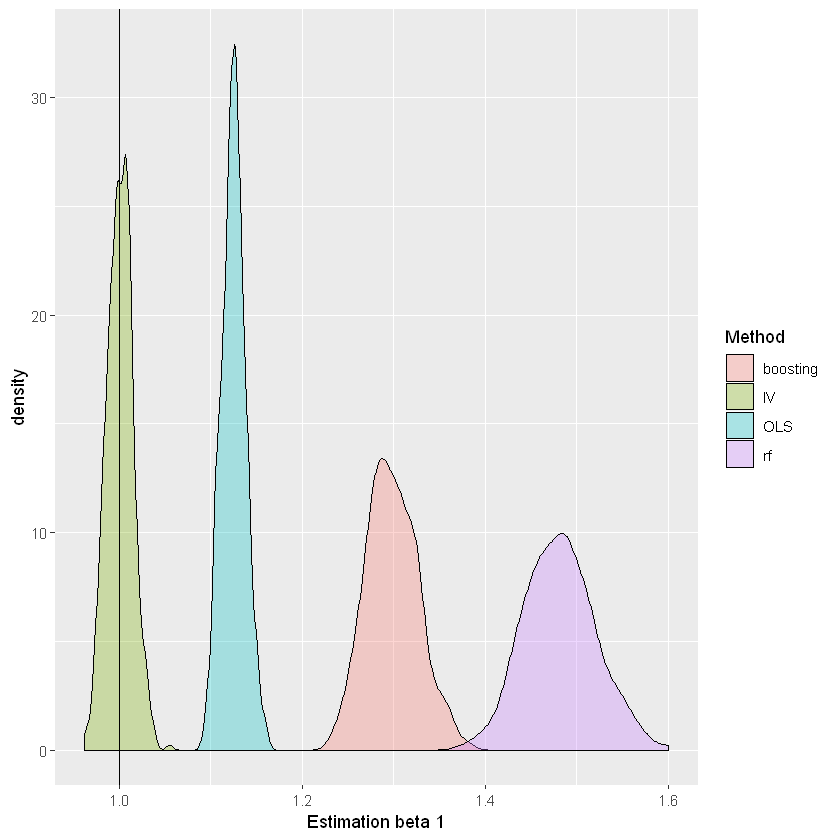

In [57]:
beta1_density_medium_c

## Case E <a class="anchor" id="E"></a>

Lennon et al (2021) present scenarios where there is only a set of strongly independent instruments, but no other exogenous covariates in the model. For this case of the simulations, I set up a scenario that simulates a case that is much closer to a real world data application. In general, when working with instrumental variables, researchers often work with one or two strong instruments and other exogenous variables for estimating the first stage. 

Thus, the following DGP simulates the same baseline DGP but with the difference that there is one strong instrument and seven other exogenous covariables, such that the DGP is:


\begin{align*}
y &= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \sum_{k=3}^{9} \beta_k x_k + \eta \\
x_2&=1 + \varepsilon_c \\
x_1&=\pi_1 z_1 + \varepsilon_c \\
\pi_1&=1 \\
\beta_0&=1 \\
\beta_1&=1 \\
\beta_2&=1 \\
\beta_3&=1 \\
\beta_4&=2 \\
\beta_5&=3 \\
\beta_6&=4 \\
\beta_7&=5 \\
\beta_8&=6 \\
\beta_9&=7 \\
\end{align*}

For a first simulation in this new setting, the exogenous variables are drawn from a multivariate normal distribution with mean zero and a  variance-covaiance matrix such that Cov$(x_k, x_j)=0$ and Var$(x_k)=1 \; \forall \; k\neq j.$ The other settings remain the same as for the baseline. 

In [4]:
set.seed(48)

dgp_medium_2 <- function(N, P, cov.mat, beta_0, beta_1, beta_2, beta_3, beta_4, beta_5,
                beta_6, beta_7, beta_8, beta_9, Mu, Sigma){
  err_c=rnorm(N, 0, 1)
  theta=runif(N, -1, 1)
  Z=data.frame(mvrnorm(N, rep(0,P), cov.mat))
  colnames(Z) <- c("z1")
  X <- data.frame(mvrnorm(N, Mu, Sigma))
  colnames(X) <- c("x3", "x4", "x5", "x6", "x7", "x8", "x9") 
  x2= 1 + err_c
  x1= Z$z1 + err_c
  y= beta_0 + beta_1*x1 + beta_2*x2 + beta_3*X$x3 + beta_4*X$x4 + beta_5*X$x5 + 
     beta_6*X$x6 + beta_7*X$x7 + beta_8*X$x8 + beta_9*X$x9 + theta
  data_sim <- data.frame("y"=y,"x1"=x1, "x2"=x2, "z"=Z, "x"=X)
  return(data_sim)
}


num_sim <- 500
n <- 1000 
p <- 1  
k<- 7 
b.0 <- 3
b.1 <- 1
b.2 <- 1
b_t <- data.frame(rbind(seq(from = 1, to = 7, length.out = k)))
colnames(b_t) <- c("b.3", "b.4", "b.5", "b.6", "b.7", "b.8", "b.9")
mu_k <- c(rep(x=0,k))
sigma_k <- diag(x=1,nrow=k,ncol=k)

ols_train_error_m2 <- rep(NA,num_sim)
ols_test_error_m2 <- rep(NA,num_sim)
iv_train_error_m2 <- rep(NA,num_sim)
iv_test_error_m2 <- rep(NA,num_sim)
two_sls_train_error_m2 <- rep(NA,num_sim)
two_sls_test_error_m2 <- rep(NA,num_sim)
rf_train_error_m2 <- rep(NA,num_sim)
rf_test_error_m2 <- rep(NA,num_sim)
boost_train_error_m2 <- rep(NA, num_sim)
boost_test_error_m2 <- rep(NA, num_sim)

c.1.1_m2 <- rep(NA,num_sim)
c.1.2_m2 <- rep(NA,num_sim)
c.2.1_m2 <- rep(NA,num_sim)
c.2.2_m2 <- rep(NA,num_sim)
c.3.1_m2 <- rep(NA,num_sim)
c.3.2_m2 <- rep(NA,num_sim)
c.4.1_m2 <- rep(NA,num_sim)
c.4.2_m2 <- rep(NA,num_sim)

s.1.2_m2 <- rep(NA,num_sim)
s.2.2_m2 <- rep(NA,num_sim)
s.3.2_m2 <- rep(NA,num_sim)
s.4.2_m2 <- rep(NA,num_sim)


cov.mat <- diag(p)

for(i in 1:num_sim){
  set.seed(i)
  data <- dgp_medium_2(N = n, P= p, cov.mat=cov.mat, beta_0=b.0, beta_1=b.1, beta_2=b.2, 
              beta_3=b_t$b.3, beta_4=b_t$b.4, beta_5=b_t$b.5, beta_6=b_t$b.6, 
              beta_7=b_t$b.7, beta_8=b_t$b.8, beta_9=b_t$b.9, Mu=mu_k, Sigma=sigma_k) 
  colnames(data) <- c("y", "x1", "x2", "z1", "x3", "x4", "x5", "x6", "x7", "x8", "x9")
  
  
  smp_size <- floor(0.7 * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  
  train_data <- data[train_ind, ]
  test_data <- data[-train_ind, ]
  
  
  naive_ols <- lm(y ~ x1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = data) 
  c.m1 <- coefficients(naive_ols)
  s.m1 <- summary(naive_ols)$coefficients[2, 2]

  naive_ols_train <- lm(y ~ x1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = train_data) 
  train_MSE_OLS = mean(naive_ols_train$residuals^2)
  ols_train_error_m2[i] <- train_MSE_OLS
  
  test_mse_ols <- test_mse(test_data, lm(y ~ x1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = test_data))
  ols_test_error_m2[i] <- test_mse_ols
  
  iv <- ivreg(y ~ x1 + x3 + x4 + x5 + x6 + x7 + x8 + x9| z1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = data)
  c.m2 <- coefficients(iv)
  s.m2<- summary(iv)$coefficients[2, 2]
  
  iv_train <- ivreg(y ~ x1 + x3 + x4 + x5 + x6 + x7| z1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = train_data)
  train_mse_iv <- mean(iv_train$residuals^2)
  iv_train_error_m2[i] <- train_mse_iv 
  
  test_mse_iv <- test_mse(test_data, ivreg(y ~ x1| z1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = test_data))
  iv_test_error_m2[i] <- test_mse_iv

  ols_1st <- lm(x1 ~ z1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, data=train_data)
  xhat_ols <- predict(ols_1st)
  ols_2nd <- lm(y ~ xhat_ols + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = train_data)
  
  ols_1st_train<- lm(x1 ~ z1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, data=train_data)
  xhat_ols_test <- predict(ols_1st_train, newdata = test_data)
  
  train_mse_2sls <- mean(ols_1st_train$residuals^2)
  test_mse_2sls <- mean((xhat_ols_test - test_data$x1)^2)
  two_sls_train_error_m2[i] <- train_mse_2sls
  two_sls_test_error_m2[i] <- test_mse_2sls
  
  
  #Random forest
  trees <- 500
  rf_1st =randomForest(x1 ~ z1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, 
                       mtry=8/3, 
                       importance=TRUE, 
                       data=train_data, 
                       ntree=trees)
    
  xhat <- predict(rf_1st)
  c.m3 = coefficients(lm(y ~ xhat + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = train_data))
  s.m3<- summary(lm(y ~ xhat + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = train_data))$coefficients[2, 2]
  
  
  rf_1st_train =randomForest(x1 ~ z1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, 
                             mtry=sqrt(8), 
                             importance=TRUE, 
                             data=train_data, 
                             ntree=trees)
    
  xhat_test <- predict(rf_1st, newdata = test_data)
  train_mse_rf <- mean(rf_1st_train$mse) 
  test_mse_rf <- mean((xhat_test - test_data$x1)^2) 
  
  rf_train_error_m2[i] <-train_mse_rf
  rf_test_error_m2[i] <- test_mse_rf
  
  
  boost_1st <- gbm(x1 ~ z1 + x3 + x4 + x5 + x6 + x7 + x8 + x9, 
                   data=train_data, 
                   distribution = "gaussian", 
                   n.trees = trees, 
                   interaction.depth = 4,
                   shrinkage = 0.01)
  
  xhat_boost <- predict(boost_1st, n.trees = trees)
  c.m4 = coefficients(lm(y ~ xhat_boost + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = train_data))
  s.m4 <- summary(lm(y ~ xhat_boost + x3 + x4 + x5 + x6 + x7 + x8 + x9, data = train_data))$coefficients[2, 2]
  
  
  
  xhat_boost_test<-predict(boost_1st, newdata= test_data, n.trees=trees)
  train_mse_b <- mean(boost_1st$train.error) 
  test_mse_b <- mean((xhat_boost_test - test_data$x1)^2) 
  
  boost_train_error_m2[i] <-train_mse_b
  boost_test_error_m2[i] <- test_mse_b
  
  c.1.1_m2[i] = c.m1[1]
  c.1.2_m2[i] = c.m1[2]  
  c.2.1_m2[i] = c.m2[1]
  c.2.2_m2[i] = c.m2[2]
  c.3.1_m2[i] = c.m3[1]
  c.3.2_m2[i] = c.m3[2]
  c.4.1_m2[i] = c.m4[1]
  c.4.2_m2[i] = c.m4[2]
  
  s.1.2_m2[i] <- s.m1
  s.2.2_m2[i] <- s.m2
  s.3.2_m2[i] <- s.m3
  s.4.2_m2[i] <- s.m4
  
}

coef_m2 <- cbind(c.1.1_m2, c.1.2_m2, c.2.1_m2, c.2.2_m2, c.3.1_m2, c.3.2_m2, c.4.1_m2, c.4.2_m2)
mi.coef_m2 <- coef_m2[,c(2,4,6, 8)]
colnames(mi.coef_m2) <- c("OLS", "IV", "rf", "boosting")
mi.coef_m2 <- melt(mi.coef_m2)
mi.coef_m2 <- mi.coef_m2[,-1]

c1<-mean(c.1.2_m2)
c2<-mean(c.2.2_m2)
c3<-mean(c.3.2_m2)
c4<-mean(c.4.2_m2)

c5<-mean(s.1.2_m2)
c6<-mean(s.2.2_m2)
c7<-mean(s.3.2_m2)
c8<-mean(s.4.2_m2)

c9<-c1-1
c10<-c2-1
c11<-c3-1
c12<-c4-1

## Case E - Results <a class="anchor" id="RE"></a>

From the variable importance graphs, it is interesting to notice that both random forest and boosting take the instrument $z_1$ as the one that has the most explanatory power in comparison with the other non correlated explanatory variables.

As to be expected, given the linear nature of the first stage regression, the tree based methods perform slighly worst than the OLS regression in predicting the endogenous variable in the first stage regression, where the test MSE of IV is 1.0186, random forest 1.0900 and boosting 1.0614. In terms of bias, in the second stage regression, the OLS shows a similar bias as in Case A where there was also only one strong instrument for the endogenous regressor $x_1$. IV again performs really well, and on average, boosting also has a bias but the first stage predictions of random forest seem to exhibit less bias than the other cases.

One could think that a reasonable explanation for this could be a better first stage prediction of random forest in this specific setting. However, previous simulations have shown that a better prediction in the first stage not necessarily produces a better second stage estimate for tree based methods. In their paper, Lennon et al (2021) present a bias decompositon, where the authors argue that the bias from nonlinear methods in the second stage come from two sources: cov$(\hat{x}_1, e) \neq 0$ (the predicted values are correlated with the first stage residuals); cov$(\hat{x}_1, u) \neq 0$ (the predicted values are correlated with the error term of the model), and $\frac{1}{Var(\hat{x})}$. 

The bias decomposition of tree based methods is a complex matter and beyond the scope of this specific project. As shown here, the extent to which a method is biased could depend on the specifications of the DGP and the structural model. Refer to the original working paper of Lennon et al (2021) for a detailed bias decomposition of ML curated first stage regressions.

,var,rel.inf
z1,z1,70.457164
x4,x4,5.498839
x8,x8,5.107022
x3,x3,4.884513
x7,x7,4.484177
x6,x6,3.938651
x5,x5,3.347673
x9,x9,2.281961


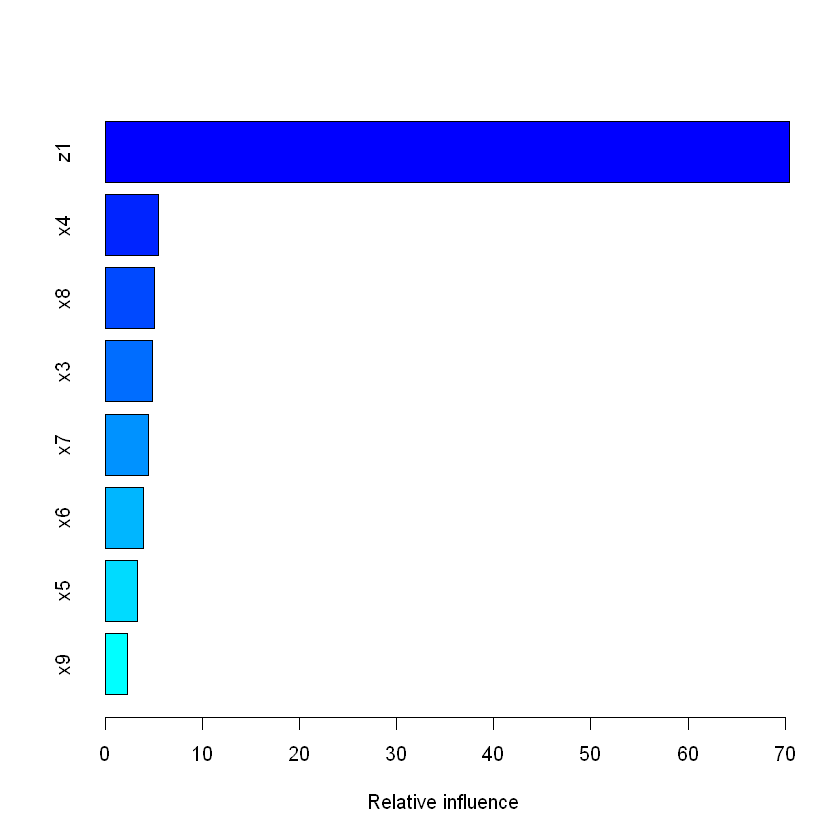

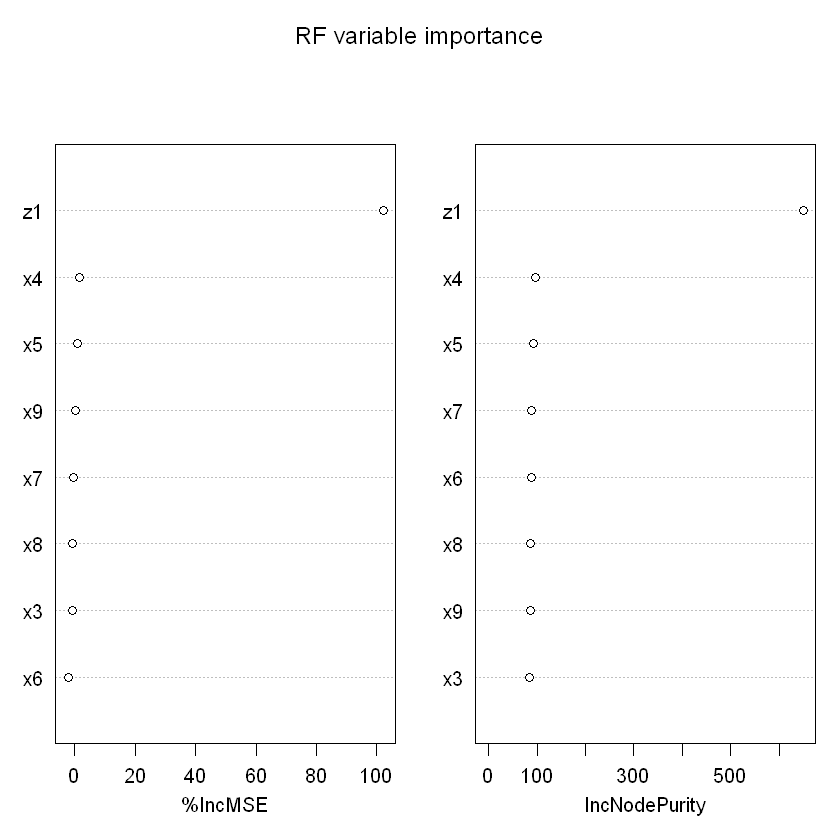

In [7]:
summary(boost_1st) #para ver importancia de las variables con boosting
varImpPlot(rf_1st, sort = T, main="RF variable importance")

In [8]:
table_1_m2<-matrix(c(mean(two_sls_train_error_m2), mean(two_sls_test_error_m2), 
                    mean(rf_train_error_m2), mean(rf_test_error_m2), mean(boost_train_error_m2), 
                    mean(boost_test_error_m2)), ncol=2, byrow=T)
colnames(table_1_m2)<-c("train error", "test error")
rownames(table_1_m2)<-c("2SLS", "RF", "Boosting")
round(table_1_m2, digits = 4)


,train error,test error
2SLS,0.9851,1.0186
RF,1.1206,1.0900
Boosting,0.9853,1.0614


In [9]:
table_2_m2 <- matrix(c(c1, c5, c9, c2, c6, c10, c3, c7, c11, c4, c8, c12), ncol=3, byrow=T)
colnames(table_2_m2) <- c("Estimate beta 1", "Std. Error", "Bias")
rownames(table_2_m2) <- c("ols", "IV", "RF", "Boosting")
round(table_2_m2, digits = 4)

,Estimate beta 1,Std. Error,Bias
ols,1.4994,0.0205,0.4994
IV,0.9954,0.0370,-0.0046
RF,1.0167,0.0880,0.0167
Boosting,1.2498,0.0747,0.2498


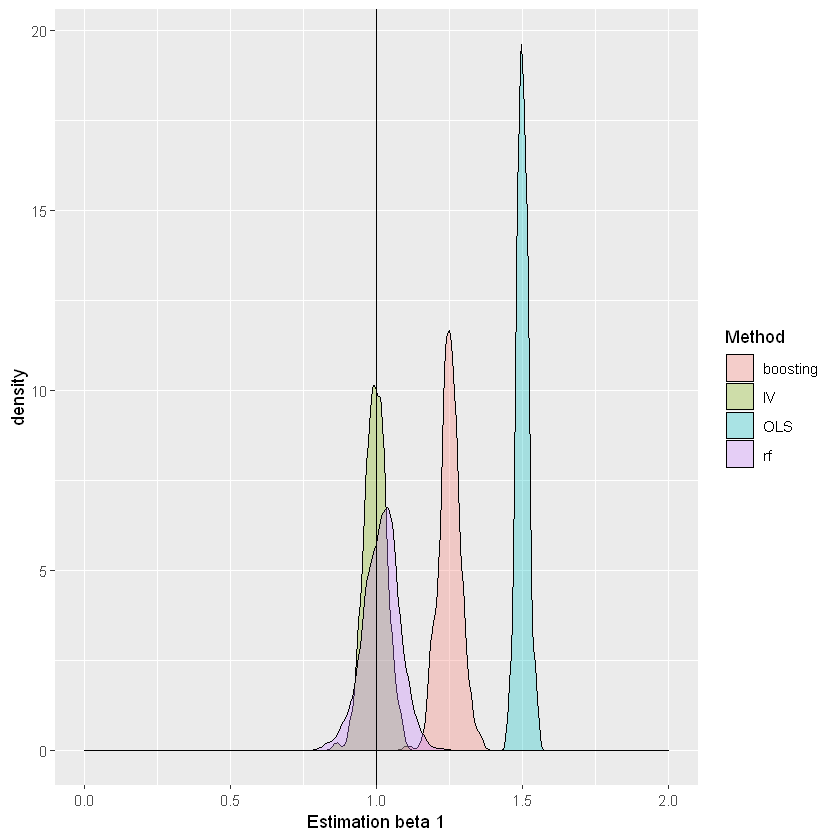

In [10]:
beta1_density_medium2 <- ggplot(mi.coef_m2, aes(x=value, fill=X2)) + geom_density(alpha=.3) +
  xlab("Estimation beta 1") + xlim(0, 2)
beta1_density_medium2 <- beta1_density_medium2 + geom_vline(xintercept = 1) + 
  guides(fill=guide_legend(title="Method"))
beta1_density_medium2

## Case F <a class="anchor" id="F"></a>

The final case is designed to showcase a setting where tree based methods clearly outperform OLS in the prediction of the first stage as a last robustness check to clearly state whether the accuracy of first stage predictions reduce the bias in the second stage. 

Here, the first stage prediction is a nonlinear equation, where $x_1$ is a nonlinear function of 5 instruments, such that the DGP follows:

\begin{align*}
y &= \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \eta \\
x_2&=1 + \varepsilon_c \\
x_1&=\pi_1 z_1 + \pi_2 z_1^2 + ... + \pi_{11} z_5^2 + \varepsilon_c \\
\pi_1&=1 \\
\beta_0&=1 \\
\beta_1&=1 \\
\beta_2&=1 \\
\pi_1&= \pi_2=...\pi_{11}=1 \\
\end{align*}

The remaining settings are the same as in the baseline DGP stated in the beginning of the section. That is, the instruments are correlated to each other following the same variance-covariance matrix, the errors are distributed the same as the baseline DGP, etc.


In [18]:
dgp_h3 <- function(N, P, cov.mat, beta_0, beta_1, beta_2){
  err_c=rnorm(N, 0, 1)
  theta=runif(N, -1, 1)
  Z=data.frame(mvrnorm(N, rep(0,P), cov.mat))
  colnames(Z) <- c("z1", "z2", "z3", "z4", "z5")
  x2= 1 + err_c
  x1= pi_1*Z$z1 + pi_2*Z$z1^2 + pi_3*Z$z2 + pi_4*Z$z2^2 + pi_7*Z$z3 + pi_6*Z$z3^2 +
    pi_8*Z$z4 + pi_9*Z$z4^2 + pi_10*Z$z5 + pi_11*Z$z5^2 + err_c
  y= beta_0 + beta_1*x1 + beta_2*x2 + theta
  data_sim <- data.frame("y"=y,"x1"=x1, "x2"=x2, "z"=Z)
  return(data_sim)
}

set.seed(48)
num_sim <- 500
n <- 1000 
p <- 5  
b.0 <- 1
b.1 <- 1
b.2 <- 1
pi_1 <- pi_2 <- pi_3 <- pi_4 <- pi_5 <- pi_6 <- pi_7 <-pi_8 <-pi_9 <-pi_10<-pi_11 <- 1

ols_train_error_h3 <- rep(NA,num_sim)
ols_test_error_h3 <- rep(NA,num_sim)
iv_train_error_h3 <- rep(NA,num_sim)
iv_test_error_h3 <- rep(NA,num_sim)
two_sls_train_error_h3 <- rep(NA,num_sim)
two_sls_test_error_h3 <- rep(NA,num_sim)
rf_train_error_h3 <- rep(NA,num_sim)
rf_test_error_h3 <- rep(NA,num_sim)

c.1.1_h3 <- rep(NA,num_sim)
c.1.2_h3 <- rep(NA,num_sim)
c.2.1_h3 <- rep(NA,num_sim)
c.2.2_h3 <- rep(NA,num_sim)
c.3.1_h3 <- rep(NA,num_sim)
c.3.2_h3 <- rep(NA,num_sim)
c.4.1_h3 <- rep(NA,num_sim)
c.4.2_h3 <- rep(NA,num_sim)

s.1.2_h3 <- rep(NA,num_sim)
s.2.2_h3 <- rep(NA,num_sim)
s.3.2_h3 <- rep(NA,num_sim)
s.4.2_h3 <- rep(NA,num_sim)
boost_train_error_h3 <- rep(NA, num_sim)
boost_test_error_h3 <- rep(NA, num_sim)

cov.mat <- diag(p)
cov.mat[outer(1:p, 1:p, function(i,j) i!=j)] <- sqrt(0.5)

for(i in 1:num_sim){
  data <- dgp_h3(N = n, P= p, cov.mat=cov.mat, beta_0=b.0, beta_1=b.1, beta_2=b.2) 
  colnames(data) <- c("y", "x1", "x2", "z1", "z2", "z3", "z4", "z5")
  
  smp_size <- floor(0.7 * nrow(data))
  train_ind <- sample(seq_len(nrow(data)), size = smp_size)
  
  train_data <- data[train_ind, ]
  test_data <- data[-train_ind, ]

  naive_ols <- lm(y ~ x1, data = data) 
  c.m1 <- coefficients(naive_ols)
  s.m1 <- summary(naive_ols)$coefficients[2, 2]
  
 
  naive_ols_train <- lm(y ~ x1, data = train_data)
  train_MSE_OLS = mean(naive_ols_train$residuals^2)
  ols_train_error_h3[i] <- train_MSE_OLS
  
  test_mse_ols <- test_mse(test_data, lm(y ~ x1, data = test_data))
  ols_test_error_h3[i] <- test_mse_ols
  
  iv <- ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5, data = data)
  c.m2 <- coefficients(iv)
  s.m2 <- summary(iv)$coefficients[2, 2]
  
  iv_train <- ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5, data = train_data)
  train_mse_iv <- mean(iv_train$residuals^2)
  iv_train_error_h3[i] <- train_mse_iv 
  
  test_mse_iv <- test_mse(test_data, ivreg(y ~ x1| z1 + z2 + z3 + z4 + z5, data = test_data))
  iv_test_error_h3[i] <- test_mse_iv
  
  ols_1st_train <- lm(x1 ~ z1 + z2 + z3 + z4 + z5, data=train_data)
  xhat_ols_test <- predict(ols_1st_train, newdata = test_data)
  
  train_mse_2sls <- mean(ols_1st_train$residuals^2)
  test_mse_2sls <- mean((xhat_ols_test - test_data$x1)^2)
  two_sls_train_error_h3[i] <- train_mse_2sls
  two_sls_test_error_h3[i] <- test_mse_2sls
  
  trees <- 500
  
  rf_1st =randomForest(x1 ~ z1 + z2 + z3 + z4 + z5, 
                       mtry=5/3, 
                       importance=TRUE, 
                       data=train_data, 
                       ntree=trees)
  xhat <- predict(rf_1st) #OOB predictions
  c.m3 = coefficients(lm(y ~ xhat, data = train_data)) 
  s.m3 <- summary(lm(y ~ xhat, data = train_data))$coefficients[2, 2]
  

  xhat_test <- predict(rf_1st, newdata = test_data)
  
  train_mse_rf <- mean(rf_1st$mse) 
  test_mse_rf <- mean((xhat_test - test_data$x1)^2) 
  
  rf_train_error_h3[i] <-train_mse_rf
  rf_test_error_h3[i] <- test_mse_rf
  
  boost_1st <- gbm(x1 ~ z1 + z2 + z3 + z4 + z5, 
                   data=train_data, 
                   distribution = "gaussian", 
                   n.trees = trees, 
                   interaction.depth = 4,
                   shrinkage = 0.01)
    
  xhat_boost <- predict(boost_1st, n.trees = trees)
  c.m4 = coefficients(lm(y ~ xhat_boost, data = train_data))
  s.m4 <- summary(lm(y ~ xhat_boost, data = train_data))$coefficients[2, 2]
  
  xhat_boost_test<-predict(boost_1st, newdata= test_data, n.trees=trees)
  
  train_mse_b <- mean(boost_1st$train.error) 
  test_mse_b <- mean((xhat_boost_test - test_data$x1)^2) 
  
  boost_train_error_h3[i] <-train_mse_b
  boost_test_error_h3[i] <- test_mse_b
  
  c.1.1_h3[i] = c.m1[1]
  c.1.2_h3[i] = c.m1[2]  
  c.2.1_h3[i] = c.m2[1]
  c.2.2_h3[i] = c.m2[2]
  c.3.1_h3[i] = c.m3[1]
  c.3.2_h3[i] = c.m3[2]
  c.4.1_h3[i] = c.m4[1]
  c.4.2_h3[i] = c.m4[2]
  
  s.1.2_h3[i] <- s.m1
  s.2.2_h3[i] <- s.m2
  s.3.2_h3[i] <- s.m3
  s.4.2_h3[i] <- s.m4
  
}

coef_h3 <- cbind(c.1.1_h3, c.1.2_h3, c.2.1_h3, c.2.2_h3, c.3.1_h3, c.3.2_h3, c.4.1_h3, c.4.2_h3)
mi.coef_h3 <- coef_h3[,c(2,4,6, 8)]
colnames(mi.coef_h3) <- c("OLS", "IV", "rf", "boosting")
mi.coef_h3 <- melt(mi.coef_h3)
mi.coef_h3 <- mi.coef_h3[,-1]

beta1_density_h3 <- ggplot(mi.coef_h3, aes(x=value, fill=X2)) + geom_density(alpha=.3) +
  xlab("Estimation beta 1")
beta1_density_h3 <- beta1_density_h3 + geom_vline(xintercept = 1) + 
  guides(fill=guide_legend(title="Method"))



f1<-mean(c.1.2_h3)
f2<-mean(c.2.2_h3)
f3<-mean(c.3.2_h3)
f4<-mean(c.4.2_h3)

f5<-mean(s.1.2_h3)
f6<-mean(s.2.2_h3)
f7<-mean(s.3.2_h3)
f8<-mean(s.4.2_h3)

f9<-f1-1
f10<-f2-1
f11<-f3-1
f12<-f4-1

The following graph verifies that the instruments are indeed nonlinear with respect to $x_1$. As one can see in the graph, they show a nonlinear relationship that is curved instead of linear. The first graph corresponds to the first instrument with respect to $x_1$, second graph second instrument and so on.

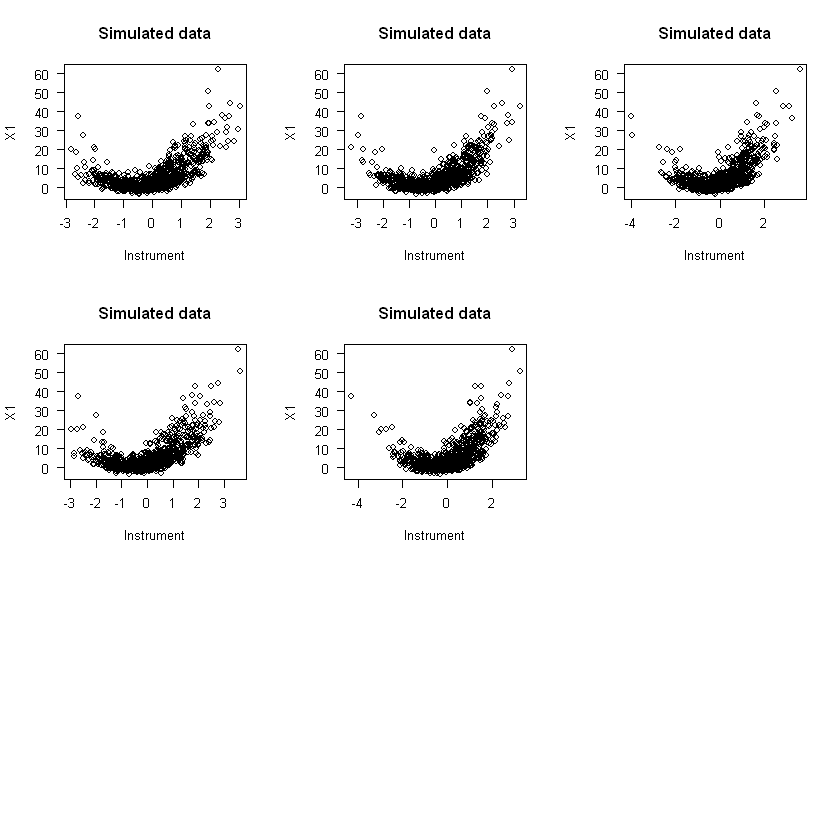

In [19]:
instr_v <- list(data$z1, data$z2, data$z3, data$z4, data$z5)
names <- c('z1', 'z2', 'z3', 'z4', 'z5')

par(mfrow=c(3,3))
for (j in instr_v){ 
  
  # Plot histogram of x
  plot(j, data$x1,
       main = "Simulated data",
       xlab = 'Instrument',
       ylab = "X1",
       col = 9,
       las = 1)
}

## Case F - Results <a class="anchor" id="RF"></a>

**First stage predictions**

As expected, the OLS performs poorly when estimating the nonlinear first regression. The boxplot shows how large the test mse is for the OLS method (also IV since it is the OLS approach for 2SLS estimation) compared to nonlinear methods. On average, the test mse for OLS is 31.3008, random forest 2.9470 and boosting 2.8969. 

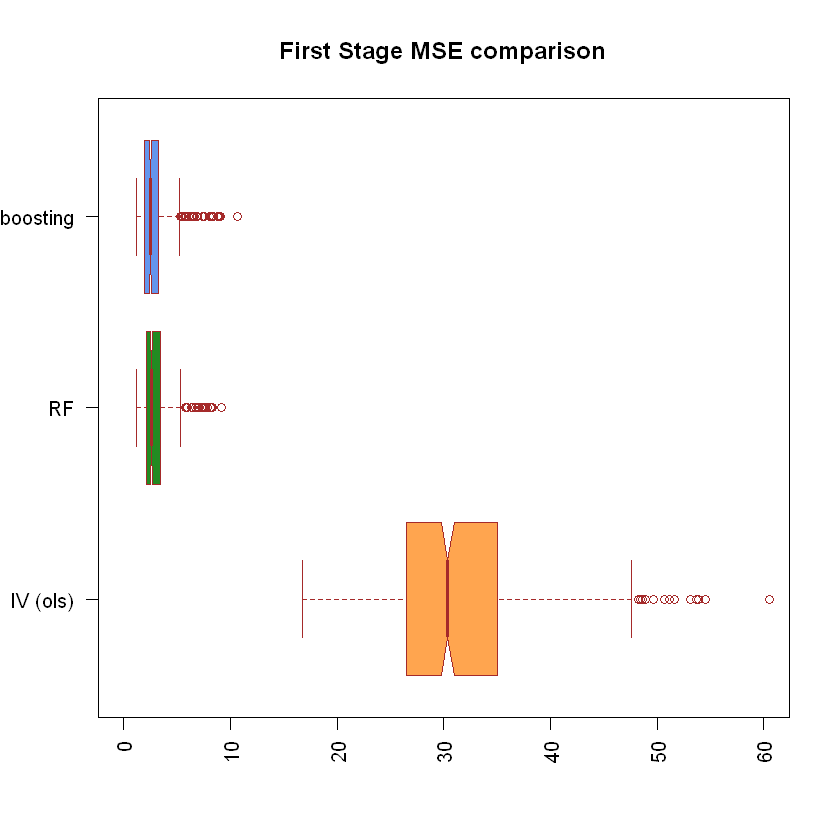

In [21]:
boxplot(two_sls_test_error_h3, rf_test_error_h3, boost_test_error_h3,
        main = "First Stage MSE comparison",
        at = c(1,2,3),
        names = c("IV (ols)", "RF", "boosting"),
        las = 2,
        col = c("tan1","forestgreen", "cornflowerblue"),
        border = "brown",
        horizontal = TRUE,
        notch = TRUE,
        ylim = c(0, 60)
)

In [20]:
table_1_h3<-matrix(c(mean(two_sls_train_error_h3), mean(two_sls_test_error_h3), 
                     mean(rf_train_error_h3), mean(rf_test_error_h3), mean(boost_train_error_h3), 
                     mean(boost_test_error_h3)), ncol=2, byrow=T)
colnames(table_1_h3)<-c("train error", "test error")
rownames(table_1_h3)<-c("2SLS", "RF", "Boosting")
round(table_1_h3, digits = 4)

,train error,test error
2SLS,30.4418,31.3008
RF,3.2098,2.9470
Boosting,9.1637,2.8969


**Second stage performance**

However, once again it is shown that a better first prediction for nonlinear methods do not assure a non biased estimator in the second stage. For comparison, consider Case B, with a similar setting but linear first stage regression. Here, tree based methods show a larger bias in comparison with Case B, which once again shows that increasing the predictivility of first stage with nonlinear methods do not solve the bias problem in the second stage-and potentially makes it worse. In this scenario, OLS bias 0.0197, random forest 0.1137 and boosting 0.0381. An interesting finding is that IV regression still makes a very acccurate two-stage estimation of the true parameter, where its bias is zero.

A potential explanation is that, even if estimating a nonlinear first stage with a linear model like OLS could be missespecified, the condition of relevance $E(x|z)\neq 0$ still holds. That means, it could be that an OLS first stage approximation is worse than a nonlinear estimation, but still captures the necessary exogenous variation to make an unbiased second stage estimation. On the other hand, nonlinear methods could be predicting well $\hat{x}$, but these predictions could be correlated with the first stage residuals, violating some necessary IV assumptions in a second stage procedure.

In [22]:
table_2_h3 <- matrix(c(f1, f5, f9, f2, f6, f10, f3, f7, f11, f4, f8, f12), ncol=3, byrow=T)
colnames(table_2_h3) <- c("Estimate beta 1", "Std. Error", "Bias")
rownames(table_2_h3) <- c("ols", "IV", "RF", "Boosting")
round(table_2_h3, digits = 4)

,Estimate beta 1,Std. Error,Bias
ols,1.0197,0.0051,0.0197
IV,1.0000,0.0084,0.0000
RF,1.1137,0.0148,0.1137
Boosting,1.0381,0.0125,0.0381


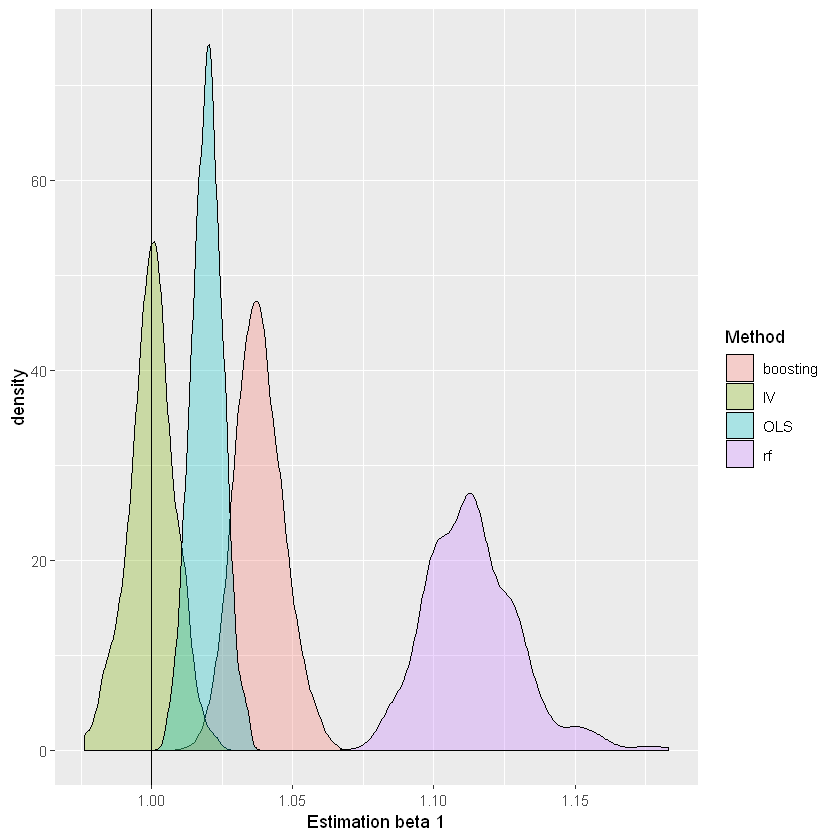

In [23]:
beta1_density_h3

-------------
# Data Application <a class="anchor" id="data"></a>

Angrist and Frandsen (2019) also identify a potential bias generated by a first-stage machine learning approximation in the context of IV. The authors argue that because random forest is not a regression, its residuals may be correlated with the covariates that made them. This could lead to a violation of orthogonalized covariates and misleading second stage estimates. According to the authors: "*This is analogous to spurious identification when a probit or logit first stage is used to instrument a dummy endogenous variable*".

In their paper, Angrist and Frandsen (2019) explore this by applying a random forest first stage estimation to the Angrist and Evans (1998) census data. The authors compare the results using both the real instrument *same sex* and an artifical instrument, where I will focus only on the results provided when using the same sex composition instrument. 

The idea of this section is then to apply the methods compared in the simulation study to a real data application. In the context of Angrist and Evans (1998), this would be similar to Case E, when there exist one instrument and several exogenous covariates. Furthermore, another aim of the data application section is to provide an extension of the simulation study for when both the endogenous variable and the instrument follow a binomial distribution (i.e., dummy variables). I will then partially compare my random forest estimations to the ones encountered in Angrist and Frandsen (2019).

## Angrist and Evans (1998) <a class="anchor" id="angrist"></a>

Angrist and Evans (1998) focus on the endogeneity problem that arises when trying to estimate the labor-supply consequence of childbearing for women. The authors use an instrumental variable approach by exploiting the parental preferences for a mixed sibling-sex composition (i.e., children of different gender) to construct instrumental variables using a same sex instrument. The same sex instrument exploits the idea that, among women with already two children, the probability of having a third child increases when having two girls or two boys as a first couple kids given parental preferences for a mixed-sex composition. 

Putting it simple, the identification strategy is as follows:

\begin{equation}
    y_i = \alpha_{0}\prime w_i + \alpha_1 s_{1i} +  \alpha_2 s_{2i}  + \beta x_i + \varepsilon_i 
\end{equation}

where $w_i$ is a vector of demographic variables-includes exogenous cofounders such as mother's age, age at first birth and race indicator-, $s_{1}$ and $s_{2}$ are indicators for whether the first child is a boy or second child is a boy and $x_i$ stands for the endogenous regressor. The outcome $y_i$ is a measure of labor supply, and the authors use several variables for it. In this case, I will use: workedm (probability of working); weeksm1 (weeks worked last year); hourswm (hours worked last year); incomem (income of mother) and famincl (family income). 

The first-stage equation relating more than 2 children to same sex is:

\begin{equation}
    x_i = \phi_{0}\prime w_i + \phi_1 s_{1i} +  \alpha_2 s_{2i}  + \lambda \ same \ sex_i + \eta_i 
\end{equation}

where $\lambda$ is the first-stage effect of the instrument.

In what follows, I provide some basic exploration of the 1980 Census Public Use Micro Samples(PUMS) used by Angrist and Evans (1998) (but I do not explore it in depth given project size constraints), and then I apply random forest and boosting for first stage approximation. Note that, since the endogenous regressor is a dummy variable, the prediction problem here is actually a **classification** task rather than a regression as seen in the simulation study. This adds a complication to the analysis, since here I do not calculate the test MSE for the first stage but the test error rate. Since OLS method is not constructed as a classification method, it is not possible to compare the performance of OLS, random forest and boosting for first stage prediction as done in the simulation study. Thus, I provide a third method not used in the simulation study - logistic regression - and compare the three methods as predictors for the first stage. Then I compare the second stage estimates for these three nonlinear methods and the OLS and IV estimations of Angrist and Evans (1998). 

In [3]:
census_1980 <- read_excel('Angrist and Evans - Data.xlsx')

In [5]:
head(census_1980)

workedm,weeksm1,hourswm,incomem,famincl,agem1,agefstm,boy1st,boy2nd,blackm,hispm,othracem,morekids,samesex
0,0,0,0.000,10.422200,27,18,1,0,0,0,0,0,0
1,52,38,18273.297,9.982413,25,19,1,0,0,0,0,0,0
1,30,40,18903.047,10.676530,30,18,0,1,0,0,0,0,0
0,0,0,0.000,10.330663,27,21,1,0,0,0,0,0,0
0,0,0,0.000,10.702120,35,27,1,0,1,0,0,0,0
1,22,35,7294.625,10.288713,30,22,0,0,0,0,0,0,1


In [9]:
summary_stats <- sumtable(census_1980,out='return')
summary_stats

Variable,N,Mean,Std. Dev.,Min,Pctl. 25,Pctl. 75,Max
workedm,394840,0.565,0.496,0,0,1,1
weeksm1,394840,20.834,22.286,0,0,49,52
hourswm,394840,18.798,18.916,0,0,40,99
incomem,394840,7160.813,10804.127,0,0,12395.617,260308
famincl,394840,10.318,1.35,0,10.099,10.91,11.967
agem1,394840,30.125,3.51,21,28,33,35
agefstm,394840,20.14,2.949,15,18,22,33
boy1st,394840,0.511,0.5,0,0,1,1
boy2nd,394840,0.511,0.5,0,0,1,1
blackm,394840,0.119,0.324,0,0,0,1


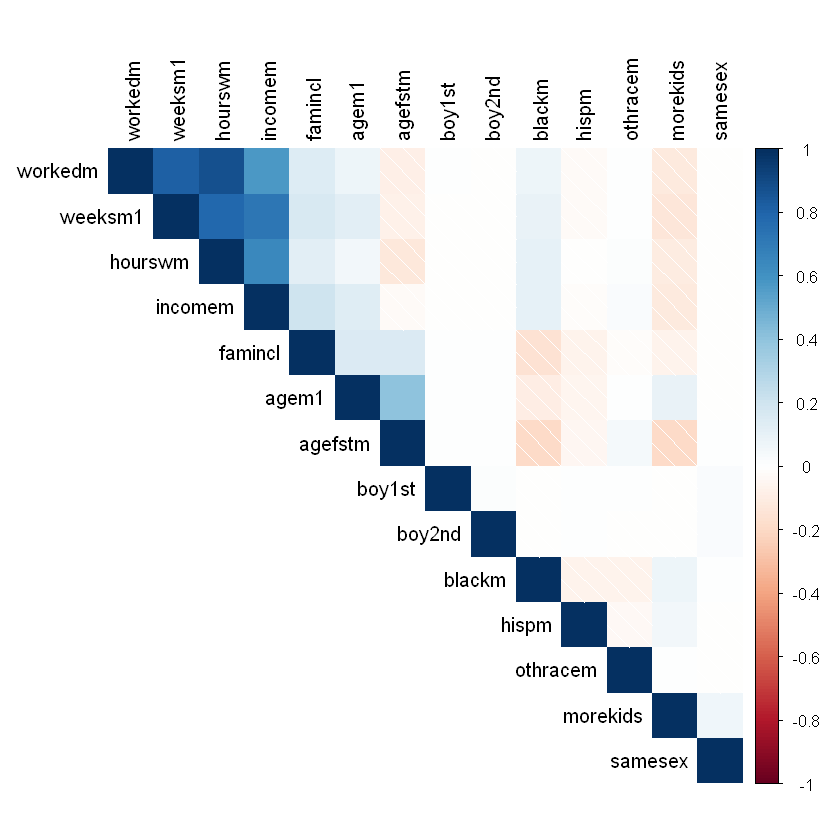

In [8]:
corrplot(cor(census_1980),
         method = "shade",
         type = "upper",
         bg = "white",
         tl.col = "black",
         shade.col = "white"# show only upper side
)

## Random Forest, Boosting and Logit - First Stage Prediction <a class="anchor" id="first"></a>

Here I apply the different non-linear models to the Angrist and Evans (1998) census data. As with the data simulation, first I compare the first stage prediction of each method, this time calculating the test error rate because the endogenous variable *more kids* is a dummy variable (1 for the woman has more than 2 kids, 0 otherwise), which reduces the first stage regression as a classification task for random forest, boosting and logit regression. For random forest, I chose 100 trees for the estimation, since it can bee seen that the error rate increases  as the number of trees grow. For boosing, I set up the tuning parameters to $B=500$, $d=1$, and $\lambda=0.1$. 

On a first glance, results show that tree based methods place the instrument in a different level of variable importance. For example, random forest places it as the fourth most important variable for *more kids* prediction, while boosting places it as the third most important variable. Both methods seem to agree that the variable that predicts the most whether a woman will have more than 2 kids or not is the age of the mother at first birth. 

As for the clasification error rate, I calculate the mean error rate of each method, which is the fraction of incorrect labels on the test data set. Here, random forest seems to perfom better, with a test error rate of 0.359, which means that the forest fails to predict if a women will have more than 2 kids 35,9% on average. Boosting performs a little worst, with a test error rate of 0.375 and logit having the worst performance of the three methods, with a test error rate of 0.597.

In [4]:
census_1980 <- census_1980 %>% select(morekids, everything())

In [5]:
#partitioning data
smp_size <- floor(0.7 * nrow(census_1980))
train_ind <- sample(seq_len(nrow(census_1980)), size = smp_size)

train_census <- census_1980[train_ind, ]
test_census <- census_1980[-train_ind, ]

In [6]:
# random forest
set.seed(28)
rf <- randomForest(morekids ~ samesex + agem1 + agefstm + boy1st + boy2nd + blackm + hispm + othracem, 
                   data=train_census, 
                   n.trees=100)


Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

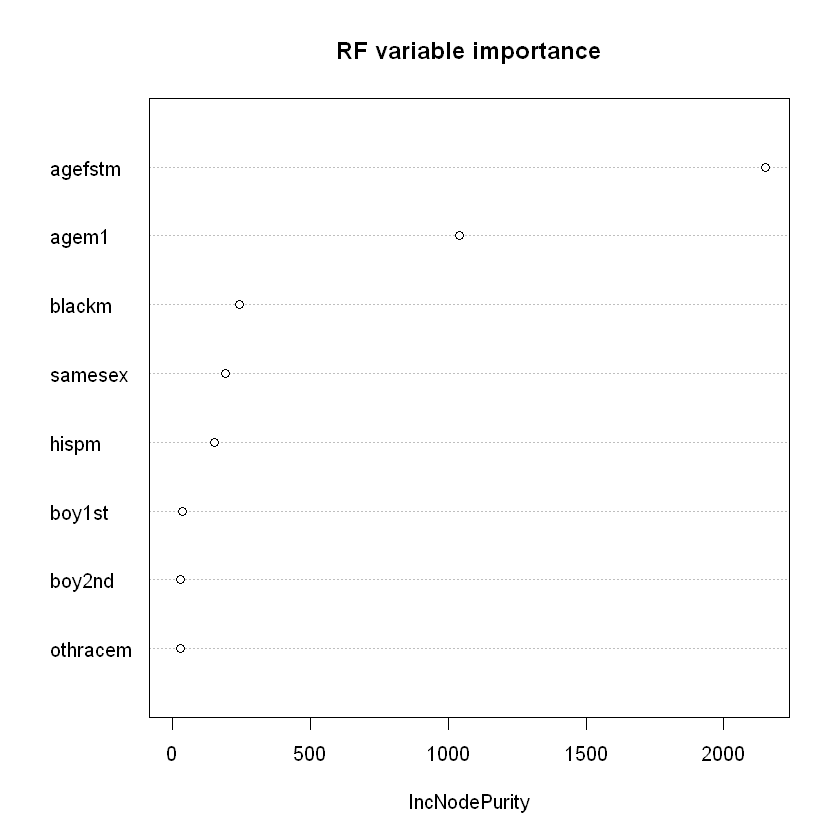

In [8]:
varImpPlot(rf, sort = T, main="RF variable importance")

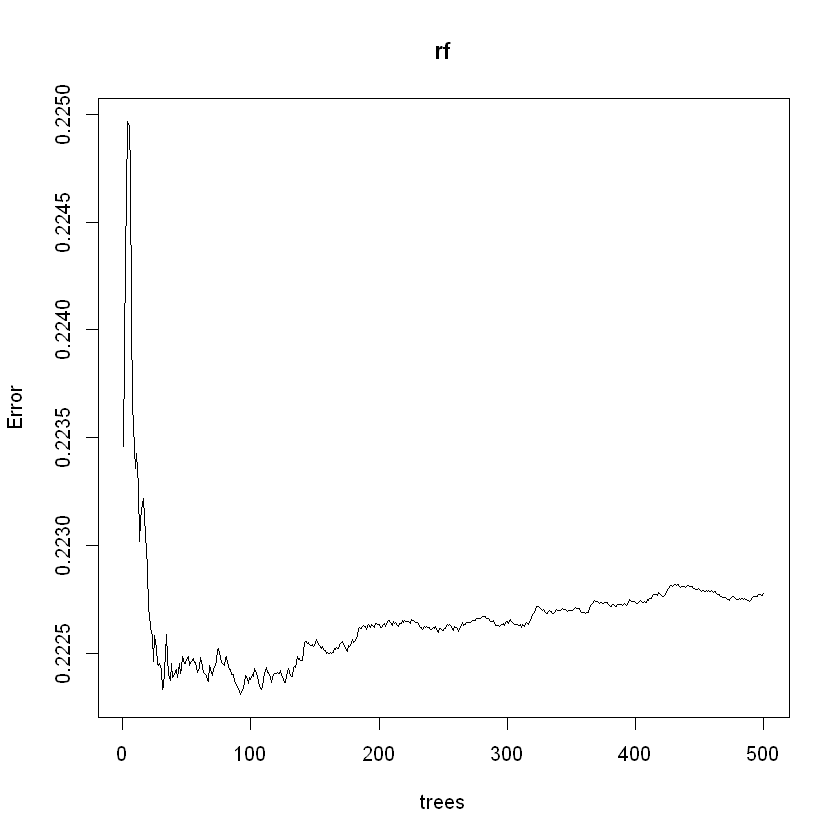

In [17]:
plot(rf)

In [9]:
rf_predict  <- predict(rf, newdata=test_census, n.trees=500, type="class")
rf_predict_1 <- ifelse(rf_predict < 0.5,0,1)
rf_cm  <- confusionMatrix(table(rf_predict_1, test_census$morekids))
rf_accuracy_rate <- rf_cm$overall[1]
rf_error_rate <- 1 - rf_accuracy_rate

In [10]:
rf_error_rate 

Accuracy 
0.3593861

OOB generally underestimates the optimal number of iterations although predictive performance is reasonably competitive. Using cv_folds>1 when calling gbm usually results in improved predictive performance.


[1] 298
attr(,"smoother")
Call:
loess(formula = object$oobag.improve ~ x, enp.target = min(max(4, 
    length(x)/10), 50))

Number of Observations: 500 
Equivalent Number of Parameters: 39.85 
Residual Standard Error: 3.071e-05

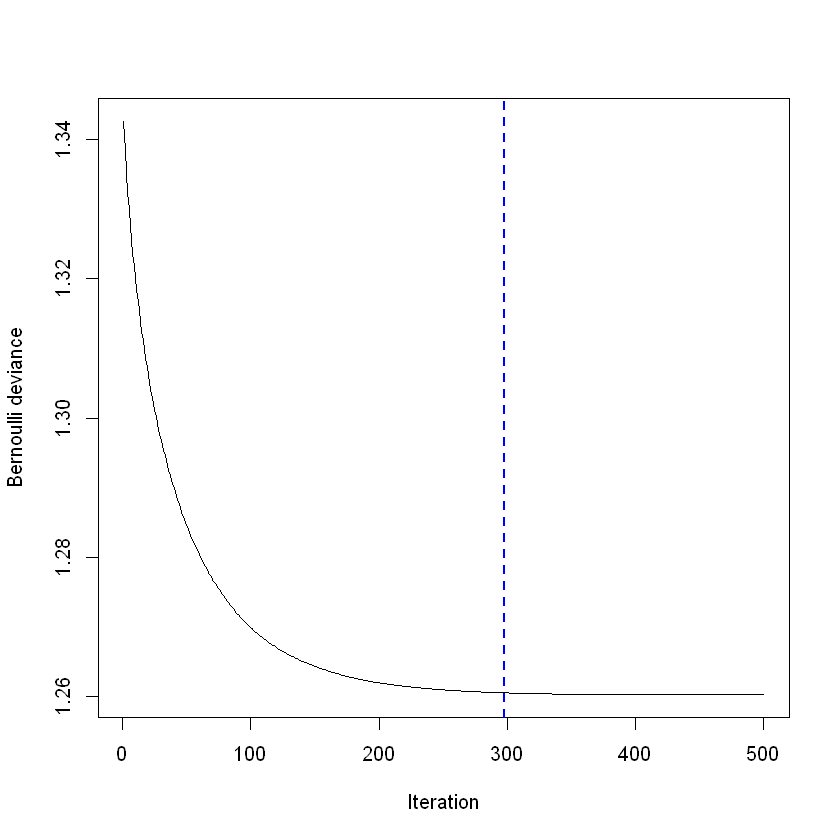

,var,rel.inf
agefstm,agefstm,56.9544678
agem1,agem1,31.2341738
samesex,samesex,4.6729708
hispm,hispm,3.1593696
blackm,blackm,2.8923738
othracem,othracem,0.7527337
boy2nd,boy2nd,0.2099269
boy1st,boy1st,0.1239836


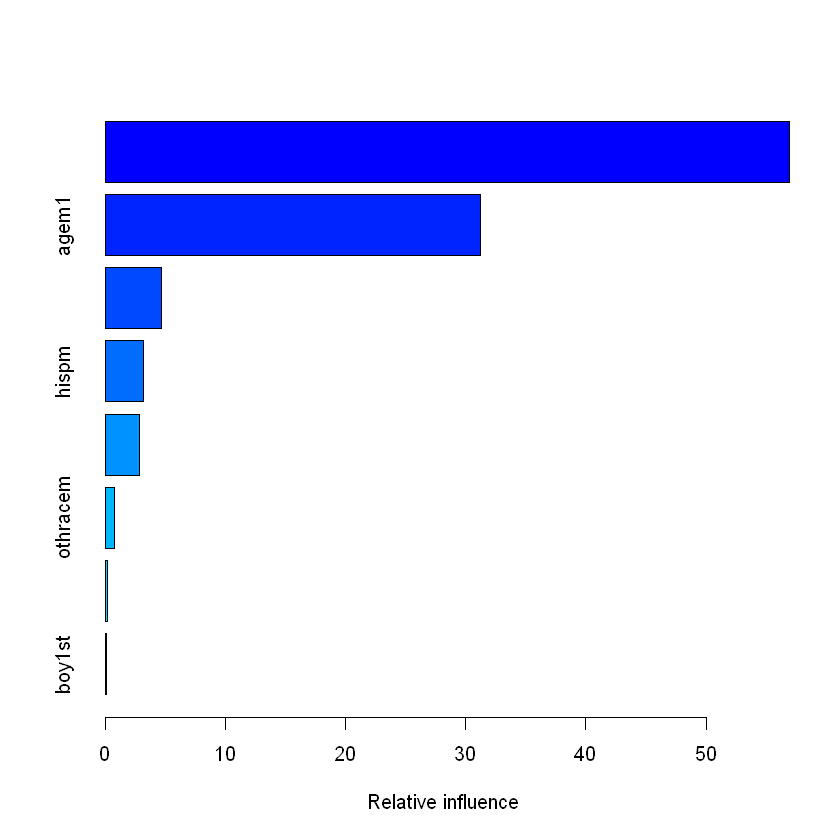

In [11]:
set.seed(28)
boost_1st <- gbm(morekids ~ samesex + agem1 + 
                     agefstm + boy1st + boy2nd + blackm + hispm + 
                     othracem, 
                   data=train_census, 
                   distribution = "bernoulli", 
                   interaction.depth = 1,
                   shrinkage = 0.1,
                   n.trees=500)
  
gbm.perf(boost_1st, plot.it = T, oobag.curve = F, method = "OOB")
summary(boost_1st)
accuracy_train<-mean(boost_1st$train.error)  

morekids_hat <- predict(boost_1st, newdata = test_census, n.trees = 500)
morekids_hat1 <- ifelse(morekids_hat < 0.5,0,1)
morekids.cm <- confusionMatrix(table(morekids_hat1, test_census$morekids))
mean.error.rate.morekids <- 1- morekids.cm$overall[1]
boosting_accuracy_test <- mean.error.rate.morekids

In [12]:
boosting_accuracy_test

Accuracy 
0.3752322

In [18]:
  #Logit model
set.seed(28)
glm_1st <- glm(morekids ~ samesex + agem1 + 
                 agefstm + boy1st + boy2nd + blackm + hispm + 
                 othracem, family = "binomial", data=train_census)


# Training error rate logit
exp <- exp(glm_1st$coefficients[1]+as.matrix(train_census[,-(1:6)])%*%glm_1st$coefficients[2:(8+1)])
x_train_prob <- exp/(1+exp)
x_train_pred <- ifelse(x_train_prob <0.5,0,1) 
train_error_rate <- ifelse(x_train_pred == train_census$morekids,0,1) 
glm_error_rate_train <- mean(train_error_rate)

# test error rate
exp <- exp(glm_1st$coefficients[1]+as.matrix(test_census[,-(1:6)])%*%glm_1st$coefficients[2:(8+1)])
x_train_prob <- exp/(1+exp)
x_train_pred <- ifelse(x_train_prob <0.5,0,1) 
test_error_rate <- ifelse(x_train_pred == test_census$morekids,0,1) 
glm_error_rate_test <- mean(test_error_rate)

In [19]:
glm_error_rate_test 

[1] 0.596689

## Second stage estimation <a class="anchor" id="second"></a>

The last table replicates Table 7 of Angrist and Evans (1998) and shows the coefficient and standard errors of *more than 2 kids predicted values* on several labor supply outcomes on the all women sample of the 1998 census. The first two columns show the results for OLS and IV regression, while the last three columns show the results for random forest, boosting and logit regression respectively. Recall that these estimates are calculated by plugging the predicted values of *more than two kids* into a normal OLS regression. As opposed to the simulation study, here we do not know the true parameter used as benchmark to compare the performance of the methods in recovering the second stage estimates. However, followiwng the simulation study, I make the assumption that the instrumental variable method comes closest to the **unknown** true parameter in the real data application. 

Results show that the three tree-based methods present "biased" estimators; that is, these estimations are different from the IV estimates. Recall Case E of the simulation study, where there was only one strong instrument and several correlated exogenous variables. The expected results should be that random forest performs almost as good as IV in terms of bias, followed by boosting and OLS. The results from random forest estimates are ambiguous; the coefficents for worked for pay, weeks worked and mother income are more aligned to the naive OLS findings than IV results. The coefficient for hours worked is the one who comes closer to the IV estimate. In terms of precision, the standard errors of random forest are very close to the ones from the IV estimates. As for the last estimate, random forest estimates seem to overestimate the effect of childbearing on the log family income compared to the OLS and IV results.

Surprisingly, boosting and logit regression present estimates that differ drastically from OLS and IV in the setting of Angrist and Evans (1998). Both methods seem to present a considerable bias, typically underestimating the effects of childbearing on the several labor supply outcomes. For example, consider the estimates of worked for pay. IV results suggest that, on average, the probability of working for women with more than 2 children decreases in 11.7%. Boosting suggests that, on average, the probability of working decreases in 4.36% and logit results indicate a decrease in probability of 2.6%. In general, both boosting and logit seem to underestimate the effects.

Finally, as a comparison of my results, I could use Angrist and Frandsen (2019) findings, where they estimate several random forest settings. However, comparison here is difficult, since the authors use the married sample of the 1980 census. However, it is interesting for the discussion to mention that the authors find that random forest estimations **differ depending on the package used and specifications**. For example, their estimates vary depending on the number of leafs set for the forests and whether the package comes from STATA (rforest) or R (grf package). Here I use the randomForest R package, which makes a small contribution to the set of random forest estimations for the given dataset.

As a conclusion from the empirical results, one could argue that no nonlinear method outperforms IV estimates in the context of Angrist and Evans (1998) data. Furthermore, boosting and logit regression seem to provide severely biased results that differ greatly from the original results of the paper, even if boosting seems to perform as good as random forest in a first stage prediction. 

In [20]:
#estimating parameters of wormed mom (probability of working or not)
set.seed(28)
morekidshat_rf <- predict(rf, n.trees=100, newdata= census_1980)
morekidshat_boost <- predict(boost_1st, n.trees=500, newdata = census_1980)
morekidshat_logit <- predict(glm_1st, newdata = census_1980)

secondstage_rf_1=lm(census_1980$workedm ~ morekidshat_rf + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c3.1 <- coefficients(secondstage_rf_1)[2]
s3.1 <- summary(secondstage_rf_1)$coefficients[2, 2]

secondstage_boost_1=lm(census_1980$workedm ~ morekidshat_boost + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c4.1 <- coefficients(secondstage_boost_1)[2]
s4.1 <- summary(secondstage_boost_1)$coefficients[2, 2]

secondstage_logit_1=lm(census_1980$workedm ~ morekidshat_logit + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c5.1 <- coefficients(secondstage_logit_1)[2]
s5.1 <- summary(secondstage_logit_1)$coefficients[2, 2]

ols = lm(workedm ~ morekids + agem1 + agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c1.1 <- coefficients(ols)[2]
s1.1 <- summary(ols)$coefficients[2, 2]

iv=ivreg(workedm ~ morekids + agem1 + agefstm + boy1st + boy2nd + 
           blackm + hispm + othracem | samesex + agem1 + 
           agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c2.1 <- coefficients(iv)[2]
s2.1 <- summary(iv)$coefficients[2, 2]

In [21]:
#estimating parameters of weeks worked
set.seed(28)
secondstage_rf_2=lm(census_1980$weeksm1 ~ morekidshat_rf + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c3.2 <- coefficients(secondstage_rf_2)[2]
s3.2 <- summary(secondstage_rf_2)$coefficients[2, 2]

secondstage_boost_2=lm(census_1980$weeksm1 ~ morekidshat_boost + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c4.2 <- coefficients(secondstage_boost_2)[2]
s4.2 <- summary(secondstage_boost_2)$coefficients[2, 2]


secondstage_logit_2=lm(census_1980$weeksm1 ~ morekidshat_logit + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c5.2 <- coefficients(secondstage_logit_2)[2]
s5.2 <- summary(secondstage_logit_2)$coefficients[2, 2]

ols = lm(weeksm1 ~ morekids + agem1 + agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c1.2 <- coefficients(ols)[2]
s1.2 <- summary(ols)$coefficients[2, 2]


iv=ivreg(weeksm1 ~ morekids + agem1 + agefstm + boy1st + boy2nd + 
           blackm + hispm + othracem | samesex + agem1 + 
           agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c2.2 <- coefficients(iv)[2]
s2.2 <- summary(iv)$coefficients[2, 2]

In [22]:
#estimating parameters of  hours worked
set.seed(28)
secondstage_rf_3=lm(census_1980$hourswm ~ morekidshat_rf + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c3.3 <- coefficients(secondstage_rf_3)[2]
s3.3 <- summary(secondstage_rf_3)$coefficients[2, 2]

secondstage_boost_3=lm(census_1980$hourswm ~ morekidshat_boost + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c4.3 <- coefficients(secondstage_boost_3)[2]
s4.3 <- summary(secondstage_boost_3)$coefficients[2, 2]

secondstage_logit_3=lm(census_1980$hourswm ~ morekidshat_logit + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c5.3 <- coefficients(secondstage_logit_3)[2]
s5.3 <- summary(secondstage_logit_3)$coefficients[2, 2]


ols = lm(hourswm ~ morekids + agem1 + agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c1.3 <- coefficients(ols)[2]
s1.3 <- summary(ols)$coefficients[2, 2]


iv=ivreg(hourswm ~ morekids + agem1 + agefstm + boy1st + boy2nd + 
           blackm + hispm + othracem | samesex + agem1 + 
           agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c2.3 <- coefficients(iv)[2]
s2.3 <- summary(iv)$coefficients[2, 2]

In [23]:
#estimating parameters of  income mom
set.seed(28)
secondstage_rf_4=lm(census_1980$incomem ~ morekidshat_rf + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c3.4 <- coefficients(secondstage_rf_4)[2]
s3.4 <- summary(secondstage_rf_4)$coefficients[2, 2]

secondstage_boost_4=lm(census_1980$incomem ~ morekidshat_boost + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c4.4 <- coefficients(secondstage_boost_4)[2]
s4.4 <- summary(secondstage_boost_4)$coefficients[2, 2]

secondstage_logit_4=lm(census_1980$incomem ~ morekidshat_logit + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c5.4 <- coefficients(secondstage_logit_4)[2]
s5.4 <- summary(secondstage_logit_4)$coefficients[2, 2]


ols = lm(incomem ~ morekids + agem1 + agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c1.4 <- coefficients(ols)[2]
s1.4 <- summary(ols)$coefficients[2, 2]


iv=ivreg(incomem ~ morekids + agem1 + agefstm + boy1st + boy2nd + 
           blackm + hispm + othracem | samesex + agem1 + 
           agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c2.4 <- coefficients(iv)[2]
s2.4 <- summary(iv)$coefficients[2, 2]

In [24]:
#estimating parameters of  family income
set.seed(28)
secondstage_rf_5=lm(census_1980$famincl ~ morekidshat_rf + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c3.5 <- coefficients(secondstage_rf_5)[2]
s3.5 <- summary(secondstage_rf_5)$coefficients[2, 2]

secondstage_boost_5=lm(census_1980$famincl ~ morekidshat_boost + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c4.5 <- coefficients(secondstage_boost_5)[2]
s4.5 <- summary(secondstage_boost_5)$coefficients[2, 2]

secondstage_logit_5=lm(census_1980$famincl ~ morekidshat_logit + census_1980$agem1 + census_1980$agefstm + 
                       census_1980$boy1st + census_1980$boy2nd + census_1980$blackm + census_1980$hispm + 
                       census_1980$othracem)
c5.5 <- coefficients(secondstage_logit_5)[2]
s5.5 <- summary(secondstage_logit_5)$coefficients[2, 2]


ols = lm(famincl ~ morekids + agem1 + agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c1.5 <- coefficients(ols)[2]
s1.5 <- summary(ols)$coefficients[2, 2]


iv=ivreg(famincl ~ morekids + agem1 + agefstm + boy1st + boy2nd + 
           blackm + hispm + othracem | samesex + agem1 + 
           agefstm + boy1st + boy2nd + blackm + hispm + othracem, data=census_1980)
c2.5 <- coefficients(iv)[2]
s2.5 <- summary(iv)$coefficients[2, 2]

In [26]:
table_7_plus <- matrix(c(c1.1, s1.1, c2.1, s2.1, c3.1, s3.1, c4.1, s4.1, c5.1, s5.1,  
                         c1.2, s1.2, c2.2, s2.2, c3.2, s3.2, c4.2, s4.2, c5.2, s5.2, 
                         c1.3, s1.3, c2.3, s2.3, c3.3, s3.3, c4.3, s4.3, c5.3, s5.3, 
                         c1.4, s1.4, c2.4, s2.4, c3.4, s3.4, c4.4, s4.4, c5.4, s5.4, 
                         c1.5, s1.5, c2.5, s2.5, c3.5, s3.5, c4.5, s4.5, c5.5, s5.5),
                         ncol=10, byrow=T)

colnames(table_7_plus) <- c("Naive OLS", "Std. Error", "IV", "Std. Error", "Random Forest", "Std. Error", "Boosting", 
                           "Std. Error", "Logit", "Std. Error")
rownames(table_7_plus) <- c("Worked for pay", "Weeks worked", "Hours worked", "Total income mom", "Log Family Income")
round(table_7_plus, digits = 4)


,Naive OLS,Std. Error,IV,Std. Error,Random Forest,Std. Error,Boosting,Std. Error,Logit,Std. Error
Worked for pay,-0.1764,0.0016,-0.1173,0.0252,-0.1502,0.0241,-0.0438,0.0053,-0.0260,0.0057
Weeks worked,-8.9782,0.0724,-5.5588,1.1178,-8.1789,1.0728,-1.7926,0.2373,-1.2333,0.2521
Hours worked,-6.6467,0.0619,-4.5468,0.9536,-4.6191,0.9123,-1.8359,0.2017,-1.0088,0.2143
Total income mom,-3762.3826,35.3804,-1902.9526,546.3798,-3197.3113,521.4844,-560.6774,115.3355,-422.2017,122.5176
Log Family Income,-0.1379,0.0044,-0.0253,0.0683,-0.5024,0.0645,0.0173,0.0143,-0.0056,0.0152


# Conclusion <a class="anchor" id="conclusion"></a>

This project aims to contribute to the just starting debate on the implications of using ML methods for causal inference settings such as IV. In particular, I focused here on whether nonlinear methods could improve first stage predictions and thus recover better second stage estimates. Lennon et al (2021) argue that ML first stage predictions result in biased second stage estimations, and so I proposed several cases where I vary the DGP proposed by the authors and analyse whether results are sensitive to DGP specifications. The simulation study is successfull in replicating the low complexity scenario of Lennon et al (2021) and the variations on their initial DGP suggest that ML methods do generate biased results in a second stage estimation, but the extent of the bias and the relative performance of each method vary according to the DGP set-up. For example, random forest seem to perform better than boosting trees in the case where there exists one strong instrument, the first stage follows a linear functional form and there exist several uncorrelated covariates. 

The data application extension of this project complements the project by implementing the methods in a setting where both endogenous and instrument variables follow a binomial distribution. I also apply then a logistic regression and the first stage prediction then becomes what is called a classification problem in the ML literature. The results show that, using the IV estimate as a benchmark, nonlinear methods yield biased results, where random forest comes close to the naive OLS estimation while boosting and logit clearly underestimate the coefficients. 

As a conclusion, ML methods should be applied carefully to IV settings, in particular when it is argued that nonlinear methods could outperfom OLS in the prediction of the endogenous regressor. ML methods create a bias as they fail to orthogonalize the predicted values with the residuals and the error terms, an assumption that its only valid to 2SLS (Lennon et al, 2021). One potential solution to this is the one proposed by Chen et al (2020), where they predict the treatment variable from the instrument and any exogenous covariates, and then use this predicted treatment and the covariates as technical instruments to recover the coefficients in the second-stage. This method is outside of the scope of the present project, but could provide a solution to the problematic found here and in other studies (Lennon et al, 2021, Angrist and Frandsen, 2019).

# References <a class="anchor" id="ref"></a>

* **Angrist, J., & Evans, W. (1998)**. *[Children and Their Parents' Labor Supply: Evidence from Exogenous Variation in Family Size](https://www.jstor.org/stable/116844)*, 88(3), The American Economic Review.

* **Angrist, J., & Frandsen, B. (2019)**. *[Machine Labor](https://www.nber.org/papers/w26584)*, National Bureau of Economic Research, Working Paper 26584.

* **Angrist, J., & Pischke, J. (2009)**. *[Mostly Harmeless Econometrics: An Empiricist´s Companion](https://www.mostlyharmlesseconometrics.com/)*, Princeton Univeristy Press.

* **Chen, J., Chen, D., & Lewis, G. (2020)**. *[Mostly Harmless Machine Learning: Learning Optimal Instruments in Linear IV Models](https://arxiv.org/abs/2011.06158), 	arXiv:2011.06158.

* **James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013)** *[An Introduction to Statistical Learning](https://link.springer.com/book/10.1007/978-1-4614-7138-7), Springer Texts in Statistics, volume 103.

* **Lennon, C., Rubin, E., & Waddell, G. (2021).** *[What can we machine learn (too much of) in 2SLS?
Insights from a bias decomposition and simulation](http://edrub.in/Papers/draft-mliv.pdf)*, Working Paper.

* **Mullainathan, S., & Spiess, J. (2017)**. *[Machine Learning: An Applied Econometric Approach](https://www.aeaweb.org/articles?id=10.1257/jep.31.2.87)*, 31(2), Journal of Economic Perspectives.

* **Varian, H. (2014)**. *[Big Data: New Tricks for Econometrics](https://www.aeaweb.org/articles?id=10.1257/jep.28.2.3)*, 28(2), Journal of Economic Perspectives.

